# xor model (from robert paper) visualization

In [1]:
import os, scipy.io 
import numpy as np 
# %matplotlib ipympl
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import axes3d

### load model

In [2]:
model_dir = '/home/nuttidalab/Documents/spikeRNN/models/DMS_OSF/'
model_fname = 'Task_xor_N_200_Taus_4.0_25.0_Act_sigmoid_2019_09_06_152659'
mat_data = scipy.io.loadmat(os.path.join(model_dir, model_fname))

In [3]:
for keys in mat_data.keys():
    print(keys)

__header__
__version__
__globals__
N
abc
activation
all_perfs
b_out
curr_mod
eval_labels
eval_loss_mean
eval_os
eval_perf_mean
exc
inh
losses
m
model_path
o
opt_scaling_factor
r
r0
scaling_factors
som_N
som_m
stability
stable_mods2
stable_outs
stable_perfs
stable_trials
target
task_path5
tau
taus
taus_gaus
taus_gaus0
tr
u
w
w0
w_in
w_in0
w_out
x
x0
auto_N
auto_N_fr
auto_c
mean_decay
new_auto_c
outs
syn_decay
taus_decay_ms
trial_spks
use_this_W


In [4]:
mat_data['tr']

array([[3301]])

(2, 500)


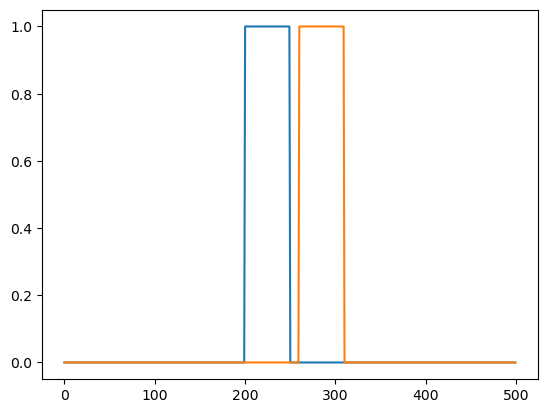

[200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 248 249]
[260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277
 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295
 296 297 298 299 300 301 302 303 304 305 306 307 308 309]


In [5]:
print(mat_data['u'].shape)
plt.plot(mat_data['u'].T)
plt.show()
print(np.where(mat_data['u'][0,:] > 0)[0])
print(np.where(mat_data['u'][1,:] > 0)[0])

### Visualize outputs

In [4]:
mat_data['eval_os'].shape

(100, 499)

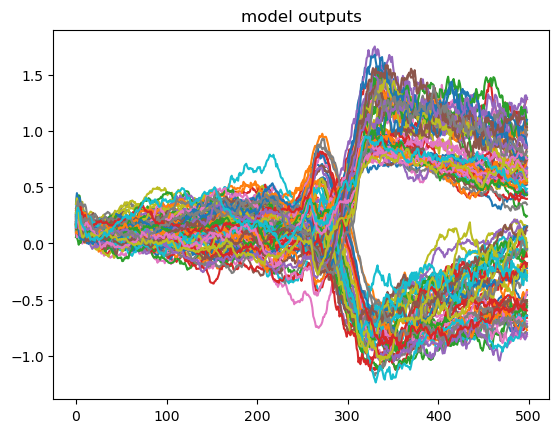

In [16]:
plt.figure()
plt.plot(np.transpose(mat_data['eval_os'][:,]))
plt.title('model outputs')
plt.show()

### get final variables

In [8]:
w = mat_data['w']
m = mat_data['m']
final_w = np.matmul(w, m)
taus_gaus = mat_data['taus_gaus']
taus = mat_data['taus'].flatten()
taus_sig = (1/(1+np.exp(-taus_gaus))*(taus[1] - taus[0])) + taus[0]

In [4]:
exc = mat_data['exc']
exc_ind = np.where(exc == 1)[0]
inh = mat_data['inh']
inh_ind = np.where(inh == 1)[0]
print(inh_ind)

[  2   5   9  26  28  34  35  39  40  51  52  62  63  68  71  73  74  79
  87  91 107 109 110 113 114 117 120 125 128 129 138 140 149 152 156 161
 165 167 174 177 179 185 191 194 196]


### model eval

In [12]:
from model import generate_input_stim_xor

2024-09-25 13:31:24.416482: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-25 13:31:24.417723: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-25 13:31:24.420771: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-25 13:31:24.427929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 13:31:24.438963: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

Instructions for updating:
non-resource variables are not supported in the long term


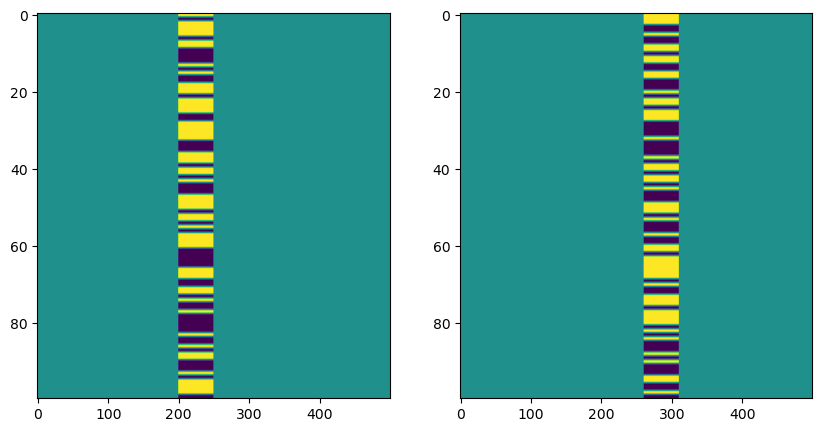

In [13]:
settings = {
        'T': 500, # trial duration (in steps)
        'stim_on': 200, # input stim onset (in steps)
        'stim_dur': 50, # input stim duration (in steps)
        'delay': 10, # delay b/w the two stimuli (in steps)
        'DeltaT': 1, # sampling rate
        'taus': 20, # decay time-constants (in steps)
        'task': 'xor', # task name
        }
inputs = np.zeros((100, 2, settings['T']))
for i in range(100):
    u, label = generate_input_stim_xor(settings)
    inputs[i, :, :] = u
# Plotting the generated trials
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(inputs[:, 0, :], aspect='auto')
axs[1].imshow(inputs[:, 1, :], aspect='auto')
plt.show()

In [7]:
import importlib
import model 

(200, 500)
(200, 500)
(500,)


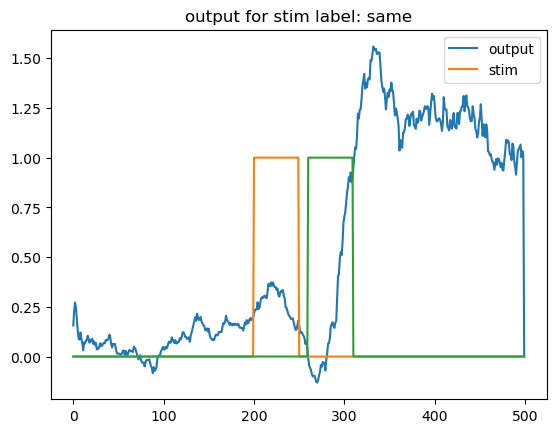

In [17]:

x, r, o, _ = model.eval_tf(model_dir=f'{model_dir}/{model_fname}', settings=settings, u=u)
print(x.shape)
print(r.shape)
print(o.shape)

plt.figure()
plt.plot(o)
plt.plot(u[0,:])
plt.plot(u[1,:])
plt.title(f'output for stim label: {label}')
plt.legend(['output','stim'])
plt.show()

In [15]:
# model eval on 100 random trials

n_trials = 100
resp_onset = settings['stim_on'] + 2*settings['stim_dur'] + settings['delay']
eval_amp_threshold = 0.7
eval_perf = np.zeros(n_trials)

for i in range(n_trials):
    eval_u, eval_label = generate_input_stim_xor(settings)
    _, _, eval_o, _ = model.eval_tf(model_dir=f'{model_dir}/{model_fname}', settings=settings, u=eval_u)
    if eval_label == 'same':
        if np.max(eval_o[resp_onset:]) > eval_amp_threshold:
            eval_perf[i] = 1
    else:
        if np.min(eval_o[resp_onset:]) < -eval_amp_threshold:
            eval_perf[i] = 1

eval_perf_mean = np.nanmean(eval_perf)
print("Performance: %.2f"%(eval_perf_mean))

Performance: 0.97


### plotting model firing rates r, and synaptic current x

In [18]:
r = mat_data['r']
x = mat_data['x']
print(r.shape)
print(x.shape)

(500, 200)
(500, 200)


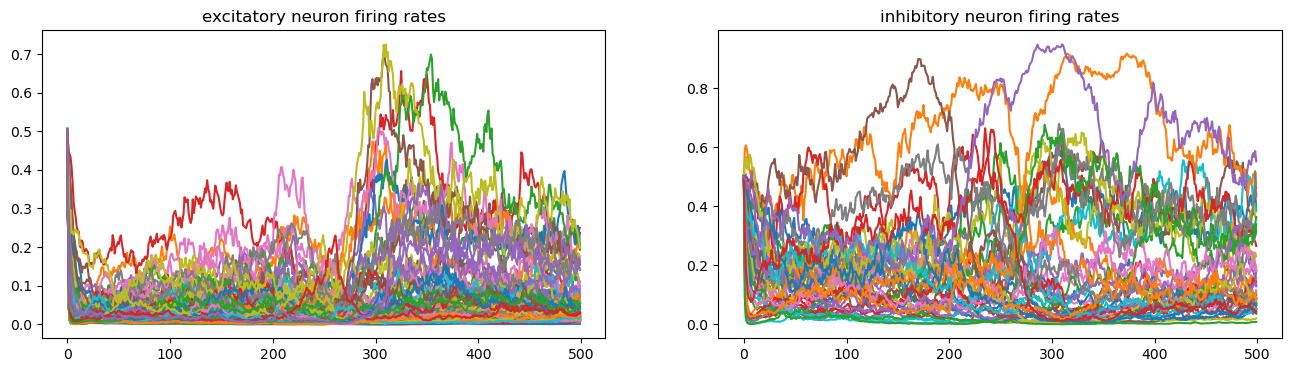

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(16,4))
axs[0].plot(r[:,exc_ind])
axs[0].set_title('excitatory neuron firing rates')
axs[1].plot(r[:,inh_ind])
axs[1].set_title('inhibitory neuron firing rates')
plt.show()

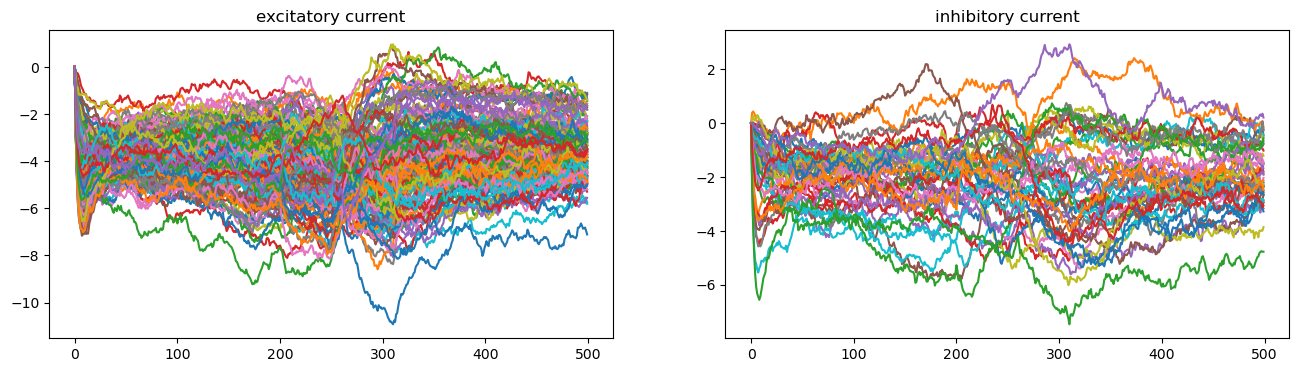

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(16,4))
axs[0].plot(x[:,exc_ind])
axs[0].set_title('excitatory current')
axs[1].plot(x[:,inh_ind])
axs[1].set_title('inhibitory current')
plt.show()

### Trajectory plots

In [7]:

from sklearn.decomposition import PCA


In [8]:
r = mat_data['r']
r.shape

(500, 200)

X (r): time x neurons  

U: time x n_components  

S: n_components  

Vt: n_components x neurons  

In [9]:
# X = USVt

pca = PCA(n_components=100).fit(r)
r_U = pca.transform(r)
r_S = pca.singular_values_
r_Vt = pca.components_

print(r_U.shape)
print(r_S.shape)
print(r_Vt.shape)

(500, 100)
(100,)
(100, 200)


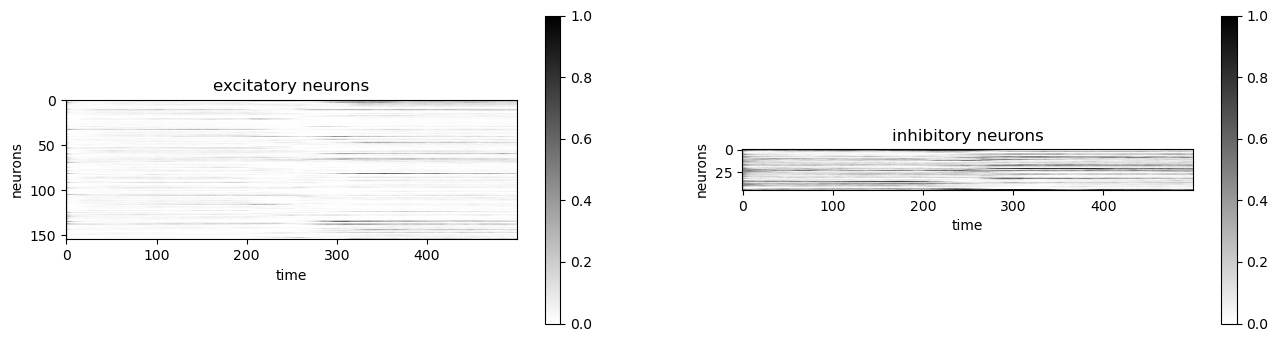

155 excitatory neurons
45 inhibitory neurons


In [25]:
fig,axs = plt.subplots(1,2,figsize=(16,4))
im1 = axs[0].imshow(r[:,exc_ind].T,cmap='binary',vmin=0, vmax=1)
axs[0].set_xlabel('time')
axs[0].set_ylabel('neurons')
axs[0].set_title('excitatory neurons')
fig.colorbar(im1)

im2 = axs[1].imshow(r[:,inh_ind].T,cmap='binary',vmin=0, vmax=1)
axs[1].set_xlabel('time')
axs[1].set_ylabel('neurons')
axs[1].set_title('inhibitory neurons')
fig.colorbar(im2)

plt.show()

print(f'{len(exc_ind)} excitatory neurons')
print(f'{len(inh_ind)} inhibitory neurons')

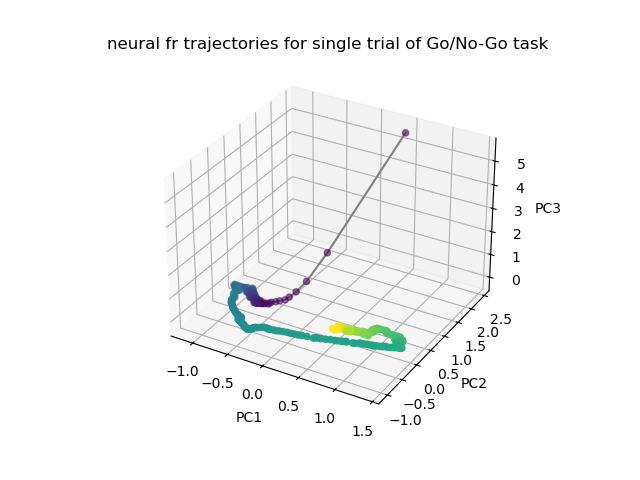

In [10]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(r_U[:,0], r_U[:,1], r_U[:,2], c=range(r_U.shape[0]))
ax.plot3D(r_U[:,0], r_U[:,1], r_U[:,2], 'gray')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('neural fr trajectories for single trial of Go/No-Go task')
plt.show()

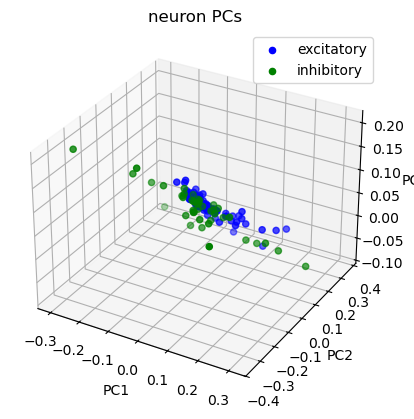

In [33]:
# neuron PCs 1, 2, 3
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(r_Vt[0,exc_ind],r_Vt[1,exc_ind], r_Vt[2,exc_ind],c='b')
ax.scatter(r_Vt[0,inh_ind],r_Vt[1,inh_ind], r_Vt[2,inh_ind], c='g')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend(['excitatory','inhibitory'])
ax.set_title('neuron PCs')
plt.show()

#### plot separate trajectories for excitatory vs inhibitory

In [35]:
# X = USVt

# excitatory
pca_exc = PCA(n_components=10).fit(r[:,exc_ind])
r_U_exc = pca_exc.transform(r[:,exc_ind])
print(r_U_exc.shape)

# inhibitory
pca_inh = PCA(n_components=10).fit(r[:,inh_ind])
r_U_inh = pca_inh.transform(r[:,inh_ind])
print(r_U_inh.shape)

(500, 10)
(500, 10)


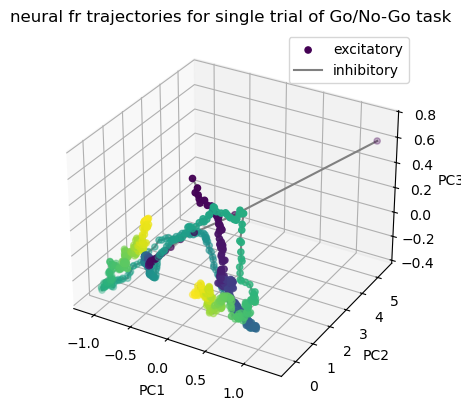

In [36]:
ax = plt.figure().add_subplot(projection='3d')

ax.scatter(r_U_exc[:,0], r_U_exc[:,1], r_U_exc[:,2], c=range(r_U_exc.shape[0]))
ax.plot3D(r_U_exc[:,0], r_U_exc[:,1], r_U_exc[:,2], 'gray')

ax.scatter(r_U_inh[:,0], r_U_inh[:,1], r_U_inh[:,2], c=range(r_U_inh.shape[0]))
ax.plot3D(r_U_inh[:,0], r_U_inh[:,1], r_U_inh[:,2], 'gray')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('neural fr trajectories for single trial of Go/No-Go task')
ax.legend(['excitatory','inhibitory'])
plt.show()

#### plot separate trajectories for multiple trials (colored by same / diff)

In [11]:
def generate_xor_type(T, stim_on, stim_dur, delay, stim1=1, stim2=-1):
     
     u = np.zeros((2, T))
     
     u[0, stim_on:stim_on+stim_dur] = stim1
     u[1, stim_on+stim_dur+delay:stim_on+2*stim_dur+delay] = stim2

     if stim1 == stim2:
          label = 'same'
     else: 
          label = 'diff'
     
     return u, label

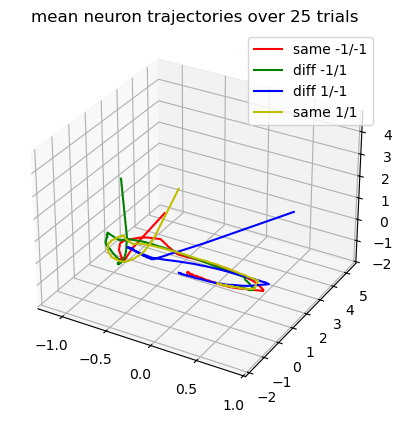

In [17]:
# model eval on 25 trials of each trial combo

n_trials = 25
n_neurons = 200
n_pcs = 3
eval_amp_threshold = 0.7
eval_perf = np.zeros(n_trials)
resp_onset = settings['stim_on'] + 2*settings['stim_dur'] + settings['delay']

stim1s = [-1, 1]
stim2s = [-1, 1]

ax = plt.figure().add_subplot(projection='3d')
colors = ['r','g','b','y']
U_pcs_mean_all = np.zeros((len(stim1s)+len(stim2s), settings['T'], n_pcs))
for i, stim1 in enumerate(stim1s):
    for j, stim2 in enumerate(stim2s):
        u, label = generate_xor_type(settings['T'], settings['stim_on'], settings['stim_dur'], settings['delay'], stim1, stim2)

        U_pcs_all = np.zeros((n_trials, settings['T'], n_pcs))
        for k in range(n_trials):
            x, r, o, _ = model.eval_tf(model_dir=f'{model_dir}/{model_fname}', settings=settings, u=u)
            r = r.T

            # do PCA
            U_pcs_all[k,:,:] = PCA(n_components=n_pcs).fit(r).transform(r)
        U_pcs_mean = np.mean(U_pcs_all, axis=0)
        U_pcs_mean_all[2*i+j,:,:] = U_pcs_mean
        ax.plot3D(U_pcs_mean[:,0], U_pcs_mean[:,1], U_pcs_mean[:,2], label=f'{label} {stim1}/{stim2}', c=colors[2*i+j])

ax.set_title(f'mean neuron trajectories over {n_trials} trials')
ax.legend()
plt.show()

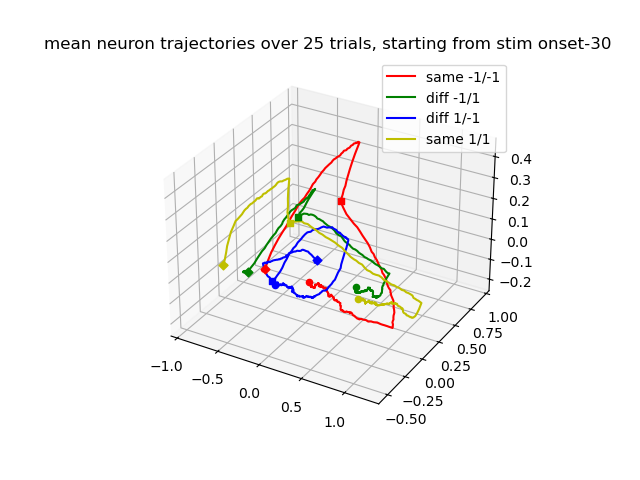

In [13]:
# model eval on 25 trials of each trial combo, plotting only after first stimulus

n_trials = 25
n_neurons = 200
n_pcs = 3
eval_amp_threshold = 0.7
eval_perf = np.zeros(n_trials)
resp_onset = settings['stim_on'] + 2*settings['stim_dur'] + settings['delay']
stim1_onset = settings['stim_on']
stim2_onset = settings['stim_on'] + settings['stim_dur'] + settings['delay']

stim1s = [-1, 1]
stim2s = [-1, 1]

ax = plt.figure().add_subplot(projection='3d')
colors = ['r','g','b','y']
U_pcs_mean_all = np.zeros((len(stim1s)+len(stim2s), settings['T'], n_pcs))
for i, stim1 in enumerate(stim1s):
    for j, stim2 in enumerate(stim2s):
        u, label = generate_xor_type(settings['T'], settings['stim_on'], settings['stim_dur'], settings['delay'], stim1, stim2)

        U_pcs_all = np.zeros((n_trials, settings['T'], n_pcs))
        for k in range(n_trials):
            x, r, o, _ = model.eval_tf(model_dir=f'{model_dir}/{model_fname}', settings=settings, u=u)
            r = r.T

            # do PCA
            U_pcs_all[k,:,:] = PCA(n_components=n_pcs).fit(r).transform(r)
        U_pcs_mean = np.mean(U_pcs_all, axis=0)
        U_pcs_mean_all[2*i+j,:,:] = U_pcs_mean
        ax.plot3D(U_pcs_mean[stim1_onset-30:,0], U_pcs_mean[stim1_onset-30:,1], U_pcs_mean[stim1_onset-30:,2], 
                  label=f'{label} {stim1}/{stim2}', c=colors[2*i+j])
        
        ax.scatter(U_pcs_mean[stim1_onset,0], 
                   U_pcs_mean[stim1_onset,1], 
                   U_pcs_mean[stim1_onset,2], 
                   c=colors[2*i+j], marker="D")
        ax.scatter(U_pcs_mean[stim2_onset,0], 
                   U_pcs_mean[stim2_onset,1], 
                   U_pcs_mean[stim2_onset,2], 
                   c=colors[2*i+j], marker="s")

ax.set_title(f'mean neuron trajectories over {n_trials} trials, starting from stim onset-30')
ax.legend()
plt.show()

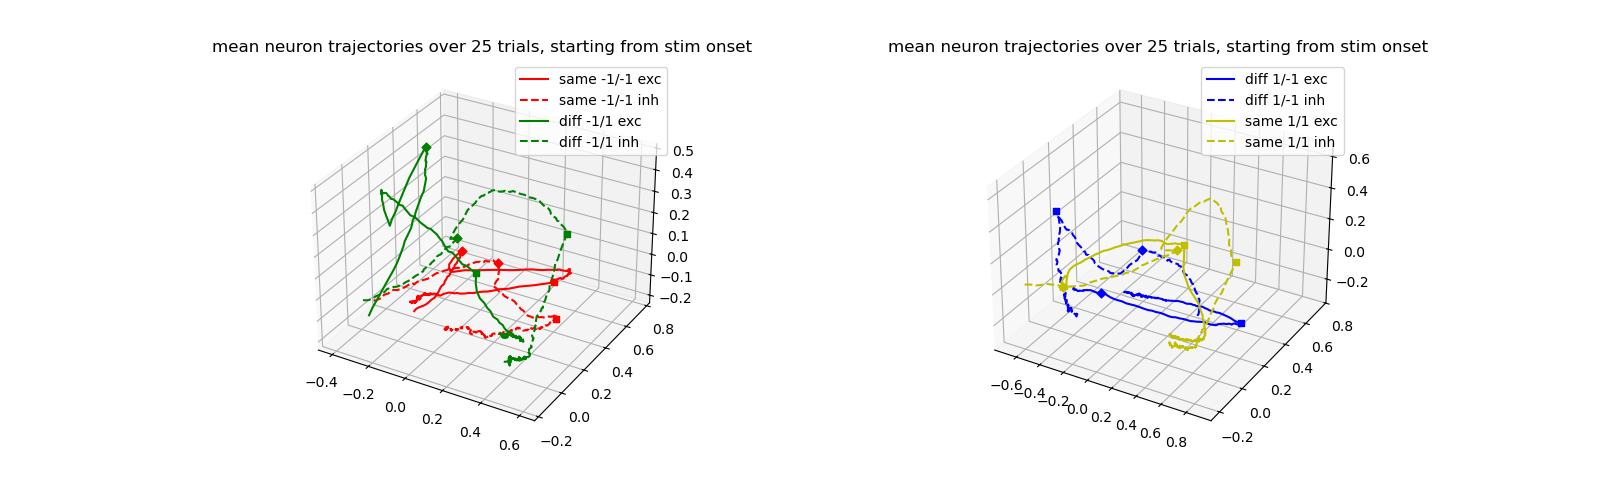

In [14]:
# model eval on 25 trials of each trial combo, splitting exc/inh neurons

n_trials = 25
n_neurons = 200
n_pcs = 3
eval_amp_threshold = 0.7
eval_perf = np.zeros(n_trials)
resp_onset = settings['stim_on'] + 2*settings['stim_dur'] + settings['delay']

stim1s = [-1, 1]
stim2s = [-1, 1]

fig, axs = plt.subplots(1,2,figsize=(16,5),subplot_kw=dict(projection='3d'))
colors = ['r','g','b','y']
for i, stim1 in enumerate(stim1s):
    for j, stim2 in enumerate(stim2s):
        u, label = generate_xor_type(settings['T'], settings['stim_on'], settings['stim_dur'], settings['delay'], stim1, stim2)

        U_pcs_all_exc = np.zeros((n_trials, settings['T'], n_pcs))
        U_pcs_all_inh = np.zeros((n_trials, settings['T'], n_pcs))
        for k in range(n_trials):
            x, r, o, _ = model.eval_tf(model_dir=f'{model_dir}/{model_fname}', settings=settings, u=u)
            r = r.T

            # do PCA
            U_pcs_all_exc[k,:,:] = PCA(n_components=n_pcs).fit(r[:,exc_ind]).transform(r[:,exc_ind])
            U_pcs_all_inh[k,:,:] = PCA(n_components=n_pcs).fit(r[:,inh_ind]).transform(r[:,inh_ind])
        U_pcs_mean_exc = np.mean(U_pcs_all_exc, axis=0)
        U_pcs_mean_inh = np.mean(U_pcs_all_inh, axis=0)
        axs[i].plot3D(U_pcs_mean_exc[settings['stim_on']:,0], U_pcs_mean_exc[settings['stim_on']:,1], U_pcs_mean_exc[settings['stim_on']:,2], 
                  label=f'{label} {stim1}/{stim2} exc', c=colors[2*i+j])
        axs[i].plot3D(U_pcs_mean_inh[settings['stim_on']:,0], U_pcs_mean_inh[settings['stim_on']:,1], U_pcs_mean_inh[settings['stim_on']:,2],
                  label=f'{label} {stim1}/{stim2} inh', c=colors[2*i+j], linestyle='--')
        

        axs[i].scatter(U_pcs_mean_exc[settings['stim_on']+settings['stim_dur'],0], 
                   U_pcs_mean_exc[settings['stim_on']+settings['stim_dur'],1], 
                   U_pcs_mean_exc[settings['stim_on']+settings['stim_dur'],2], 
                   c=colors[2*i+j], marker="D")
        axs[i].scatter(U_pcs_mean_exc[resp_onset,0], 
                   U_pcs_mean_exc[resp_onset,1], 
                   U_pcs_mean_exc[resp_onset,2], 
                   c=colors[2*i+j])
        
        axs[i].scatter(U_pcs_mean_inh[settings['stim_on']+settings['stim_dur'],0],
                   U_pcs_mean_inh[settings['stim_on']+settings['stim_dur'],1],
                   U_pcs_mean_inh[settings['stim_on']+settings['stim_dur'],2],
                   c=colors[2*i+j], marker="D")
        axs[i].scatter(U_pcs_mean_inh[resp_onset,0],
                   U_pcs_mean_inh[resp_onset,1],
                   U_pcs_mean_inh[resp_onset,2],
                   c=colors[2*i+j])

    axs[i].set_title(f'mean neuron trajectories over {n_trials} trials, starting from stim onset')
    axs[i].legend()
plt.show()

#### getting IPSCs from spiking model

In [35]:
ipsc_data = scipy.io.loadmat(os.path.join(model_dir, model_fname, 'IPSCs.mat'))
ipsc_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'diff_IPSCs', 'same_IPSCs'])

In [36]:
same_IPSCs = ipsc_data['same_IPSCs']
diff_IPSCs = ipsc_data['diff_IPSCs']
print(same_IPSCs.shape)
print(diff_IPSCs.shape)

(200, 50000)
(200, 50000)


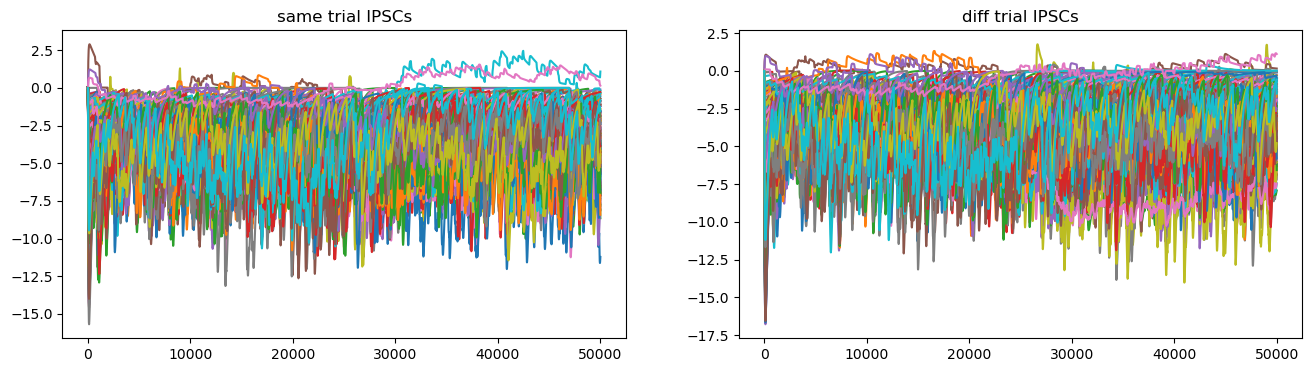

In [37]:
fig, axs = plt.subplots(1,2,figsize=(16,4))
axs[0].plot(same_IPSCs.T)
axs[0].set_title('same trial IPSCs')
axs[1].plot(diff_IPSCs.T)
axs[1].set_title('diff trial IPSCs')
plt.show()

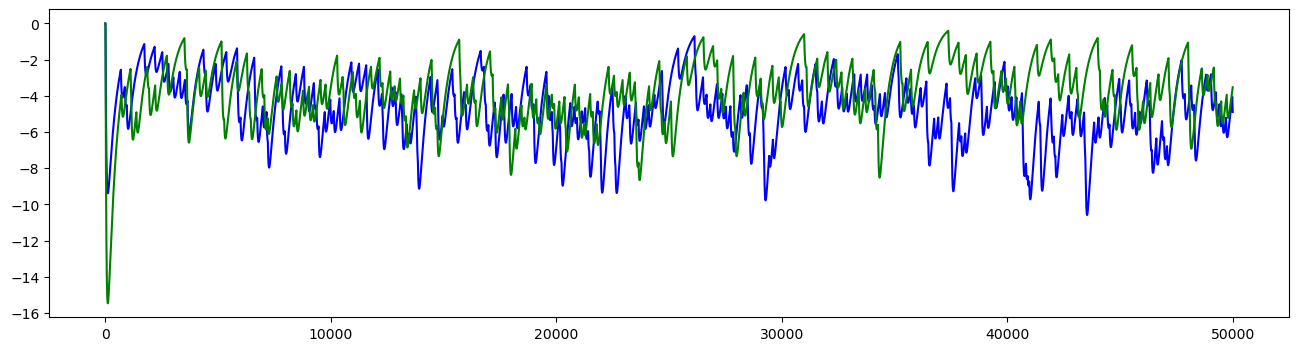

In [38]:
plt.figure(figsize=(16,4))
plt.plot(same_IPSCs[0,:].T, c='b')
plt.plot(diff_IPSCs[0,:].T, c='g')
plt.show()

### Spectrograms for IPSCs

In [39]:
from scipy.signal import spectrogram

(13,)
(2272,)
(200, 13, 2272)
[6.250000e-04 1.725000e-03 2.825000e-03 ... 2.496525e+00 2.497625e+00
 2.498725e+00]
[   0.  800. 1600. 2400. 3200. 4000. 4800. 5600. 6400. 7200. 8000. 8800.
 9600.]


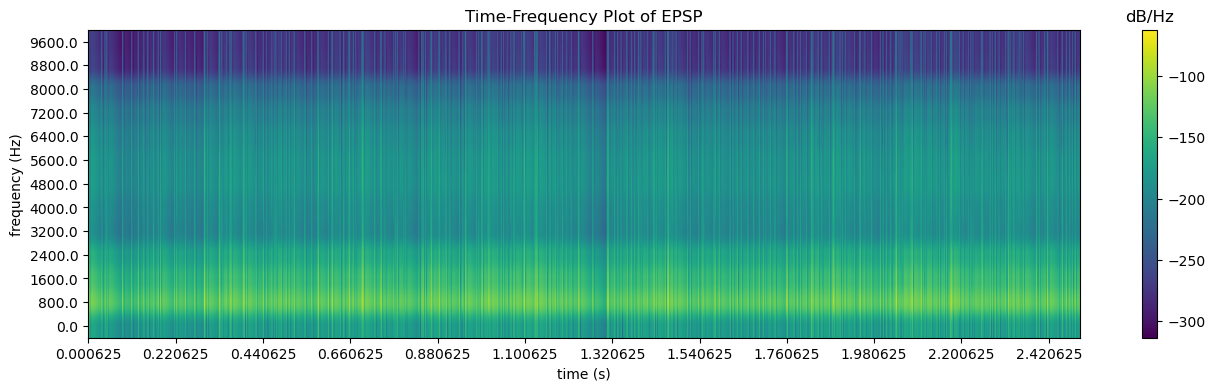

In [40]:
fs = 20000
nperseg=25

f, t, s = spectrogram(same_IPSCs, fs=fs, window=('tukey', 0.25), scaling='density', 
                      nperseg=nperseg)
# s = s[:,:,0]
print(f.shape)
print(t.shape)
print(s.shape)

print(t)
print(f)


plt.figure(figsize=(16,4))
plt.imshow(10*np.log(s[0,:,:]), aspect='auto', origin='lower')
plt.xlabel('time (s)')
plt.xticks(range(len(t))[::200],t[::200])
plt.ylabel('frequency (Hz)')
plt.yticks(range(len(f)),f)
cbar = plt.colorbar()
cbar.ax.set_title('dB/Hz')
plt.title('Time-Frequency Plot of EPSP')
plt.show()

In [17]:
def upsample(signal, fs, upsample_fs):
    # signal is (neurons x time)

    down_time = np.linspace(0, 1, fs)
    up_time = np.linspace(0, 1, upsample_fs)

    n_neurons = signal.shape[0]
    up_signal = np.zeros((n_neurons,len(up_time)))
    for i in range(n_neurons):
        intp1 = scipy.interpolate.interp1d(down_time, signal[i,:], kind='linear')
        up_signal[i,:] = intp1(up_time)

    return up_signal

In [41]:
def calc_spect(signal, fs, nperseg, noverlap, nfft, f_cutoff, 
               plot=1, neuron_nums=[0], t_skip=5, f_skip=2, trial_label='same'):
    # signal is (neurons x time)
    # neuron_num is list of neuron numbers to plot

    f, t, s = spectrogram(signal, fs=fs, window=('tukey', 0.25), 
                          nperseg=nperseg, noverlap=noverlap, nfft=nfft, scaling='density')

    f_cutoff_idx = np.where(f <= f_cutoff)[0][-1]

    if plot:
        type_label = ['excitatory','inhibitory']
        for neuron_num in neuron_nums:
            fig, axs = plt.subplots(3,1,figsize=(16,14))
            
            axs[0].plot(signal[neuron_num,:])
            axs[0].set_title(f'"{trial_label}" trial IPSC, neuron {neuron_num}, {type_label[inh[neuron_num][0]]}')

            im = axs[1].imshow(10*np.log(s[neuron_num,:f_cutoff_idx,:]), 
                               aspect='auto', origin='lower')
            axs[1].set_xlabel('time (s)')
            axs[1].set_xticks(range(len(t))[::t_skip],t[::t_skip])
            axs[1].set_ylabel('frequency (Hz)')
            axs[1].set_yticks(range(len(f[:f_cutoff_idx]))[::f_skip],f[:f_cutoff_idx][::f_skip])
            cbar = fig.colorbar(im)
            cbar.ax.set_title('dB/Hz')
            axs[1].set_title(f'Time-Frequency plot, nperseg={nperseg}, noverlap={noverlap}, nfft={nfft}')

            # plotting beta power (approx 13-30Hz)
            f_beta_idx = np.where((f >= 13) & (f <=30))[0]
            beta_power = 10*np.log(s[neuron_num,f_beta_idx,:])
            beta_mean = np.nanmean(beta_power, axis=0)
            beta_std = np.nanstd(beta_power, axis=0)
            beta_sem = np.sqrt(beta_std)/np.sqrt(beta_power.shape[0])

            axs[2].plot(beta_mean)
            axs[2].fill_between(range(len(beta_mean)), beta_mean - beta_sem, beta_mean + beta_sem, alpha=0.3)
            axs[2].set_xlabel('time (s)')
            axs[2].set_xticks(range(len(t))[::t_skip],t[::t_skip])
            axs[2].set_title('beta (13-30Hz) power')

            plt.show()

    return f, t, s

#### "same" trial

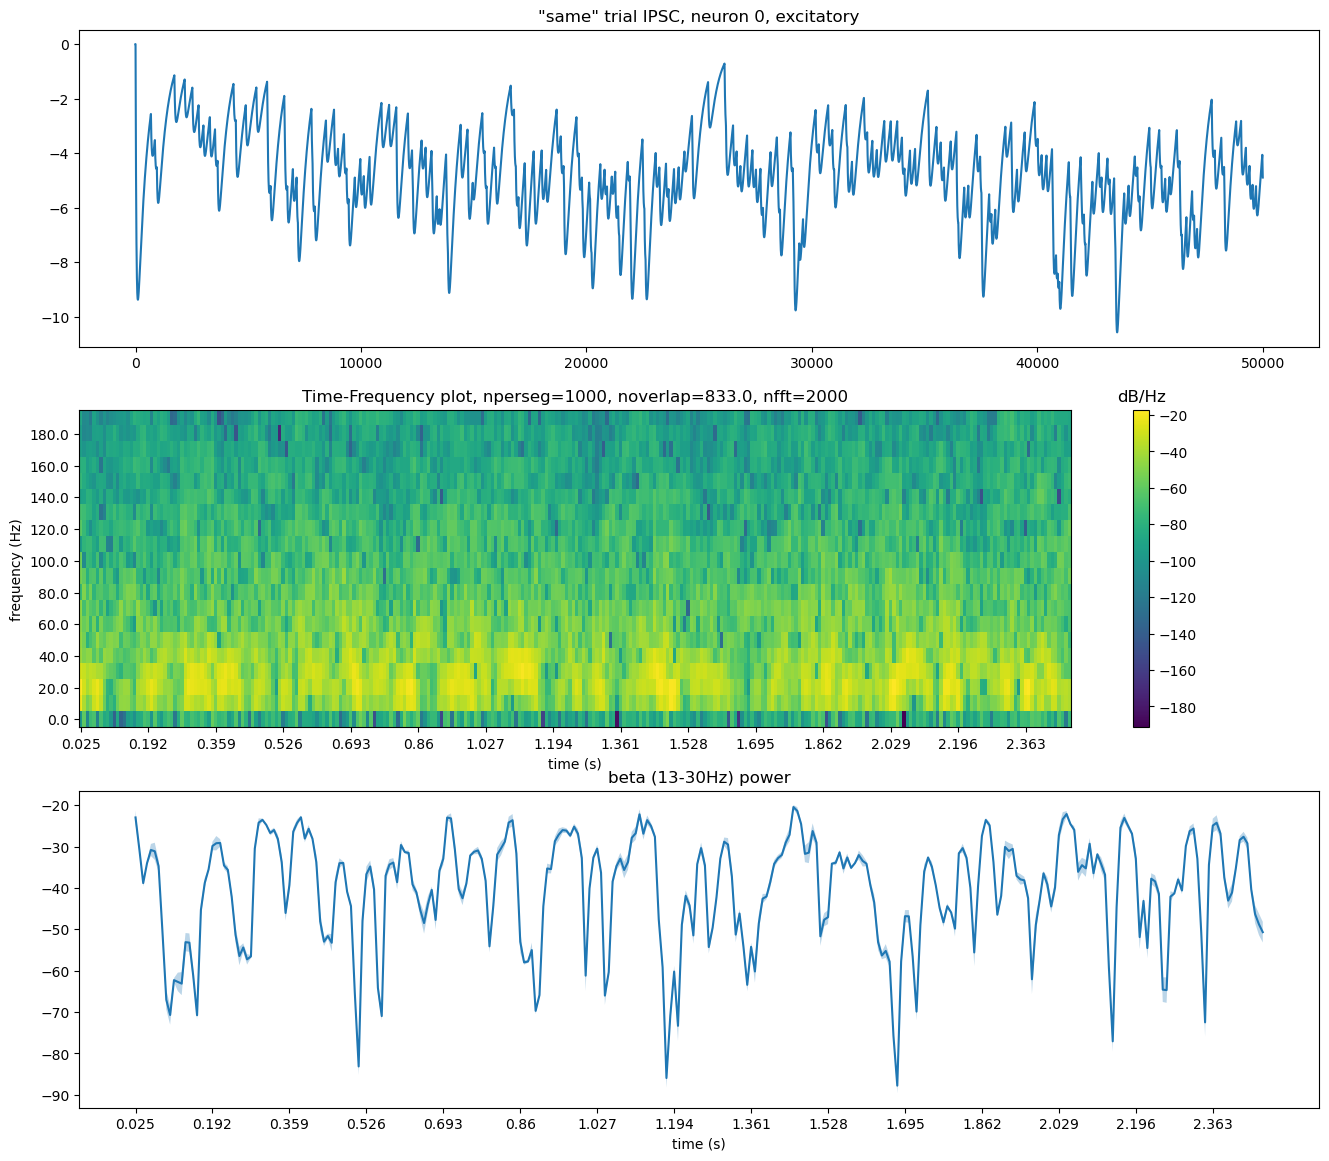

In [44]:
fs = 20000
nperseg=1000
noverlap = nperseg//1.2
nfft = nperseg*2
f_cutoff = 200

f, t, s = calc_spect(same_IPSCs, fs=fs, nperseg=nperseg, 
                     noverlap=noverlap, nfft=nfft, f_cutoff=f_cutoff, 
                     plot=1, neuron_nums=[0], t_skip=20, f_skip=2, trial_label='same')

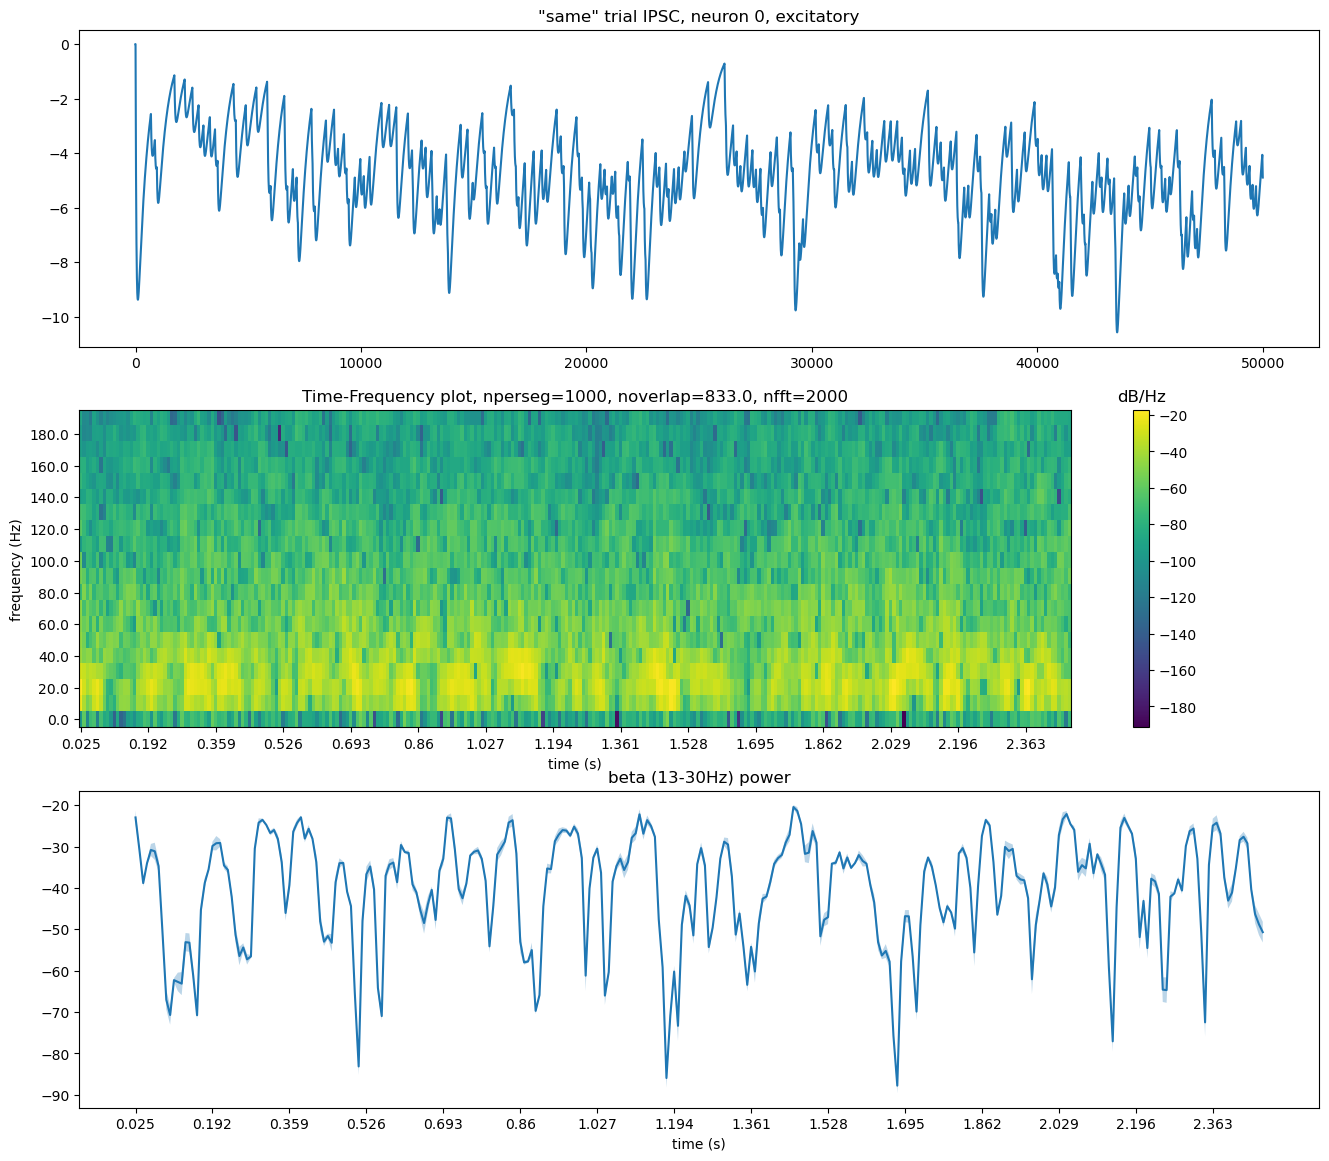

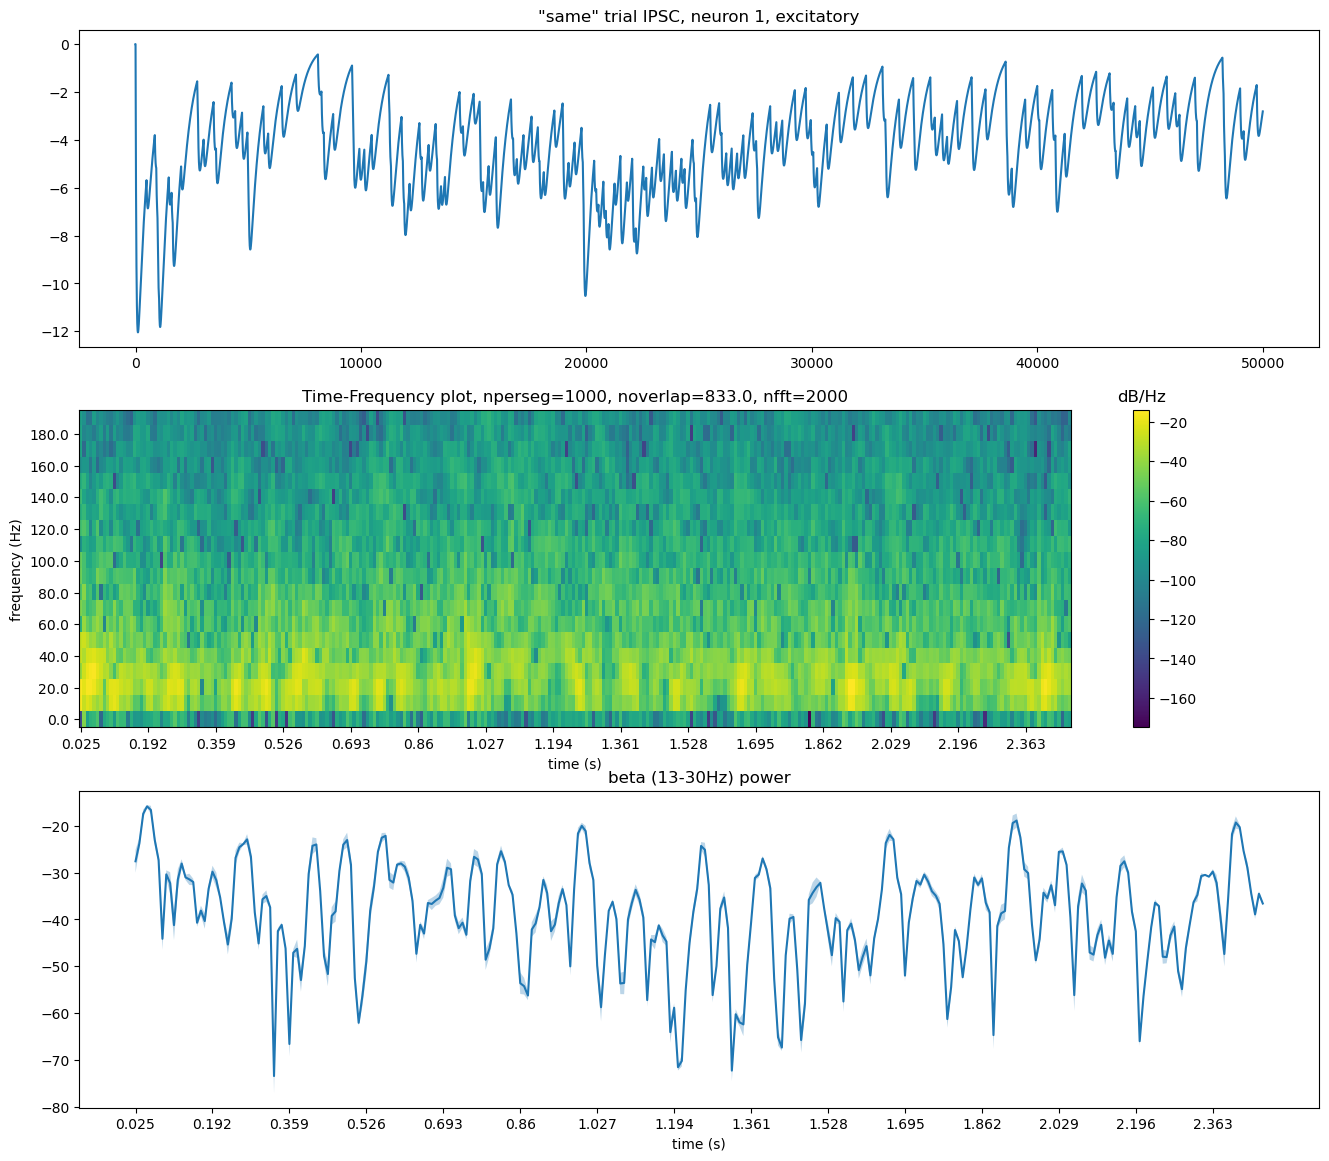

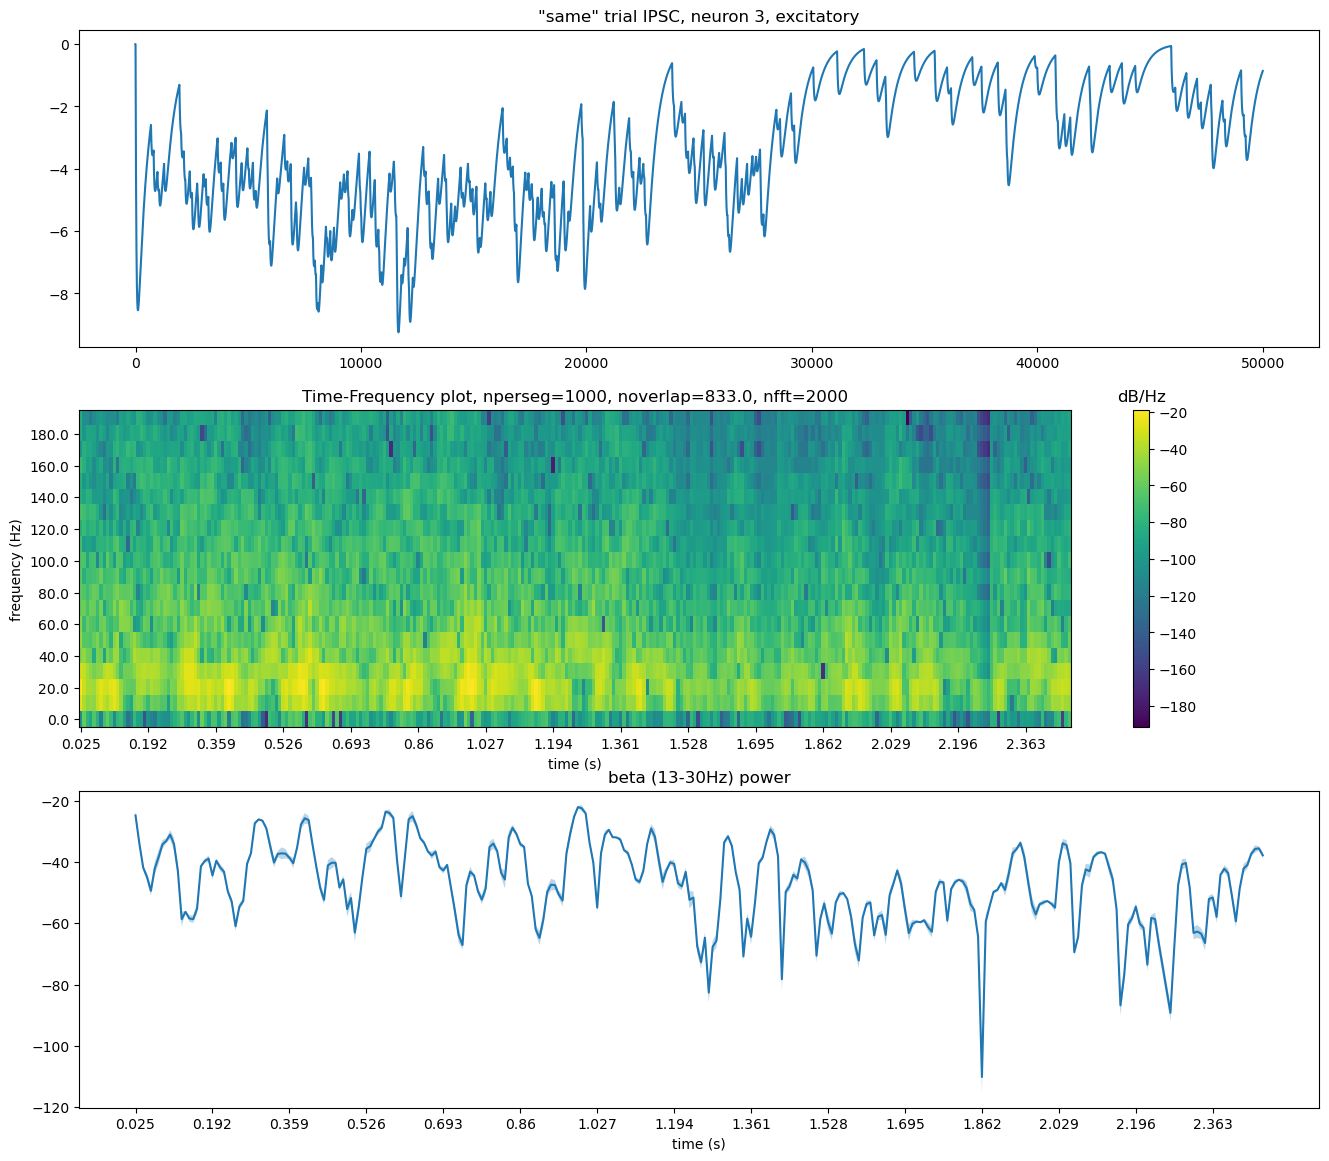

In [45]:
# plotting excitatory

fs = 20000
nperseg=1000
noverlap = nperseg//1.2
nfft = nperseg*2
f_cutoff = 200

f, t, s = calc_spect(same_IPSCs, fs=fs, nperseg=nperseg, 
                     noverlap=noverlap, nfft=nfft, f_cutoff=f_cutoff, 
                     plot=1, neuron_nums=exc_ind[:3], t_skip=20, f_skip=2, trial_label='same')

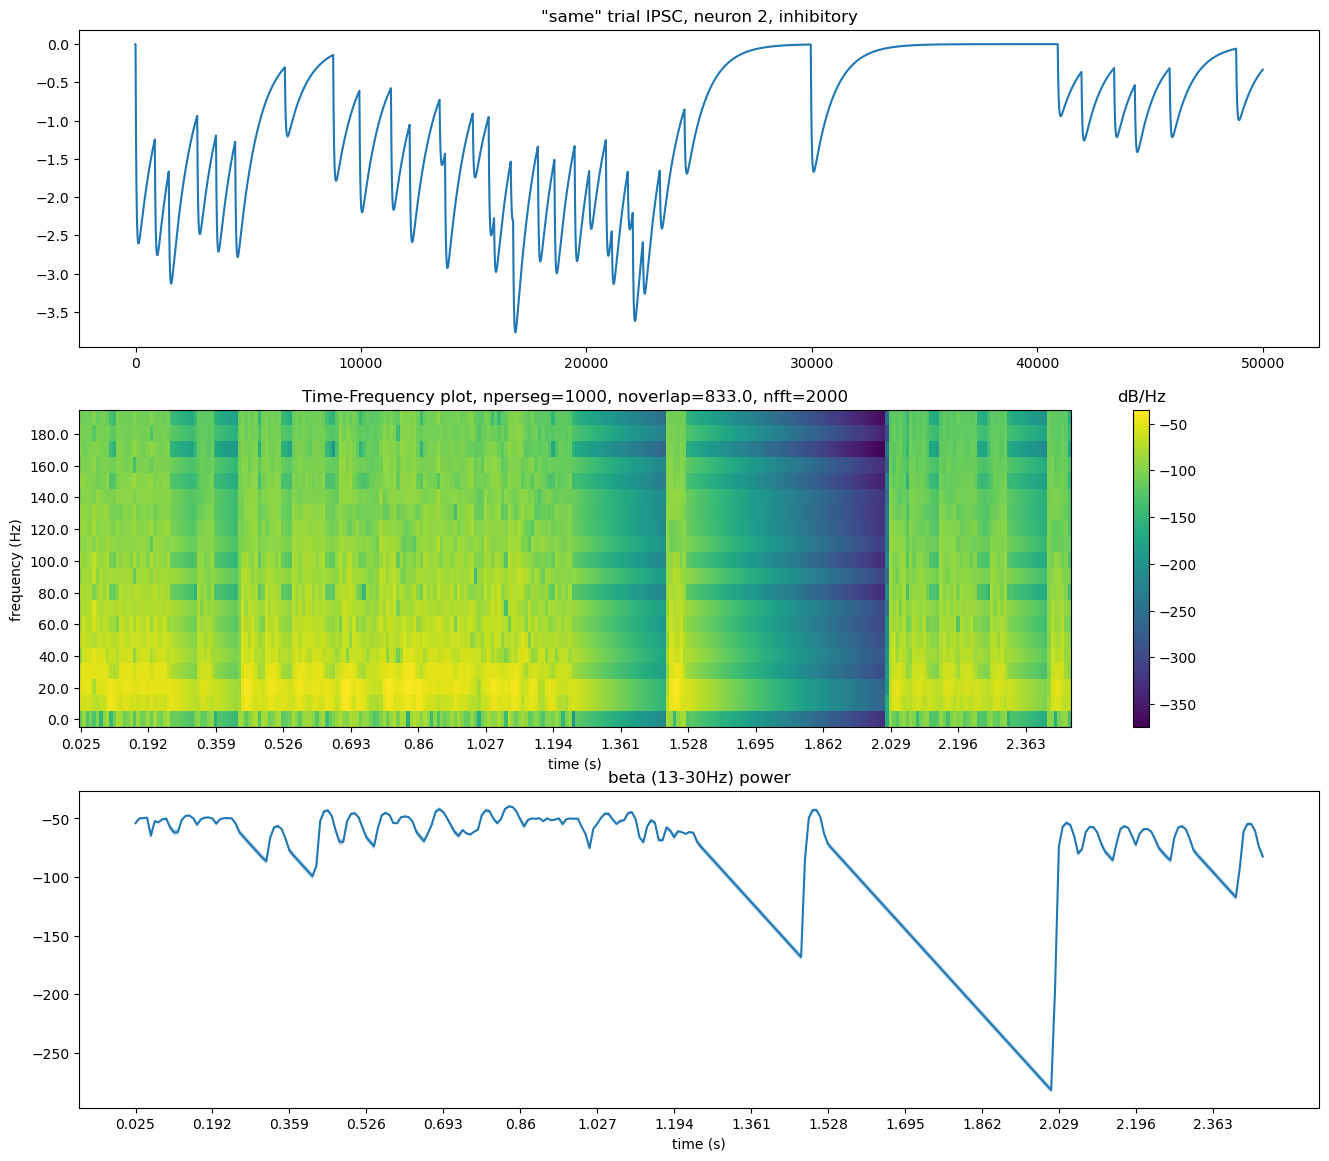

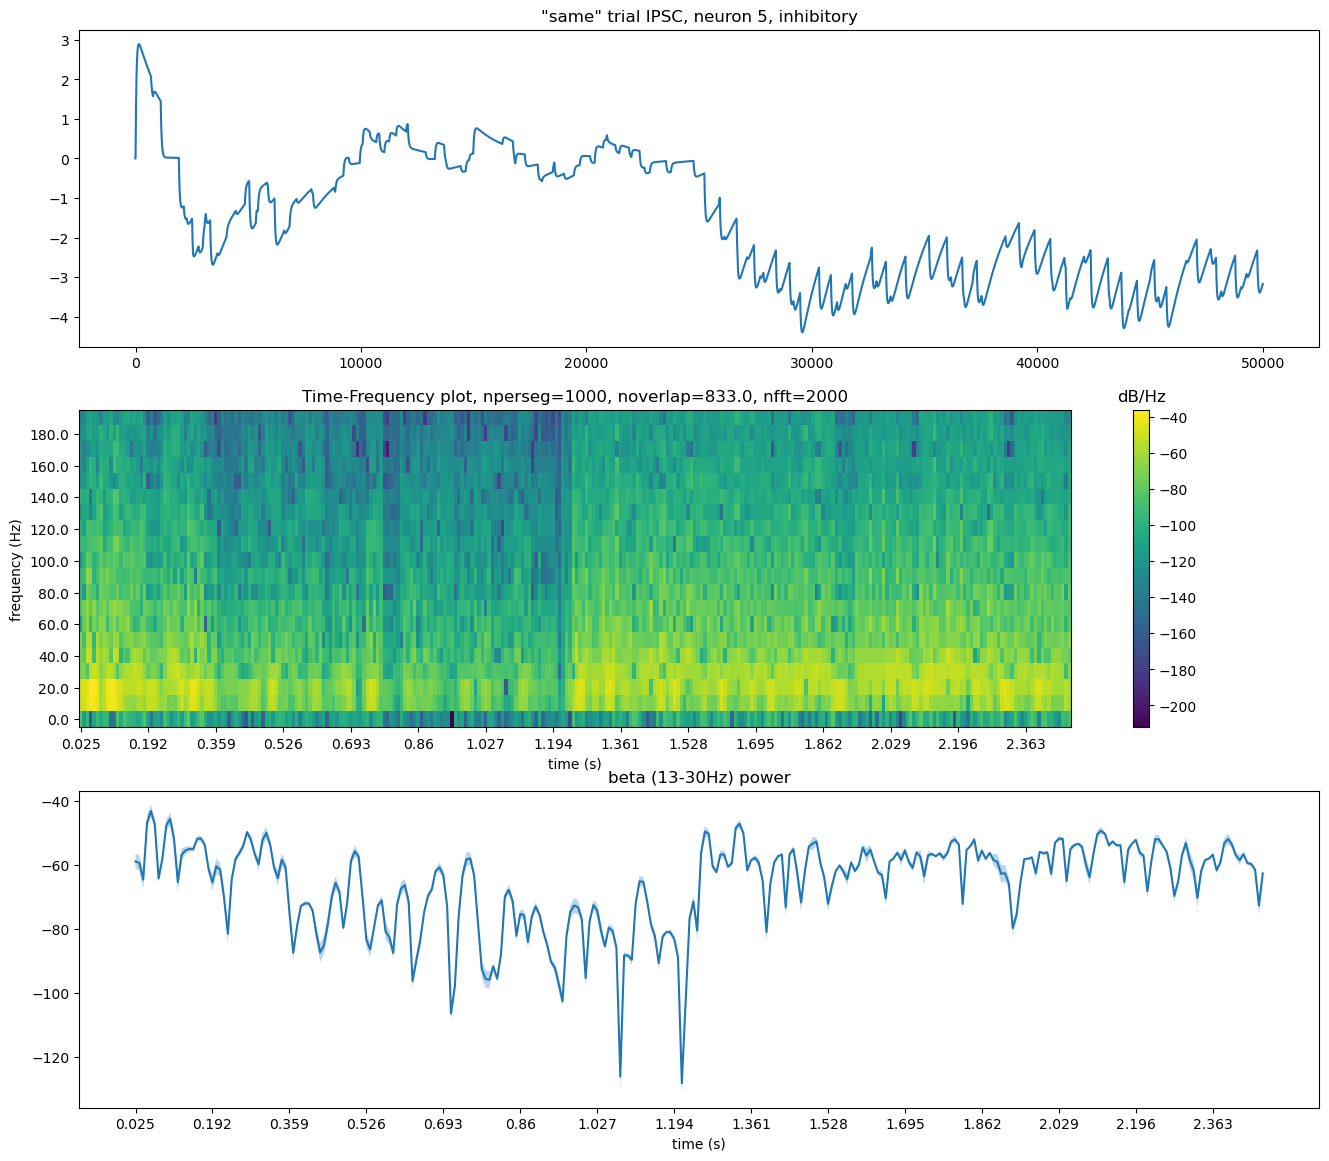

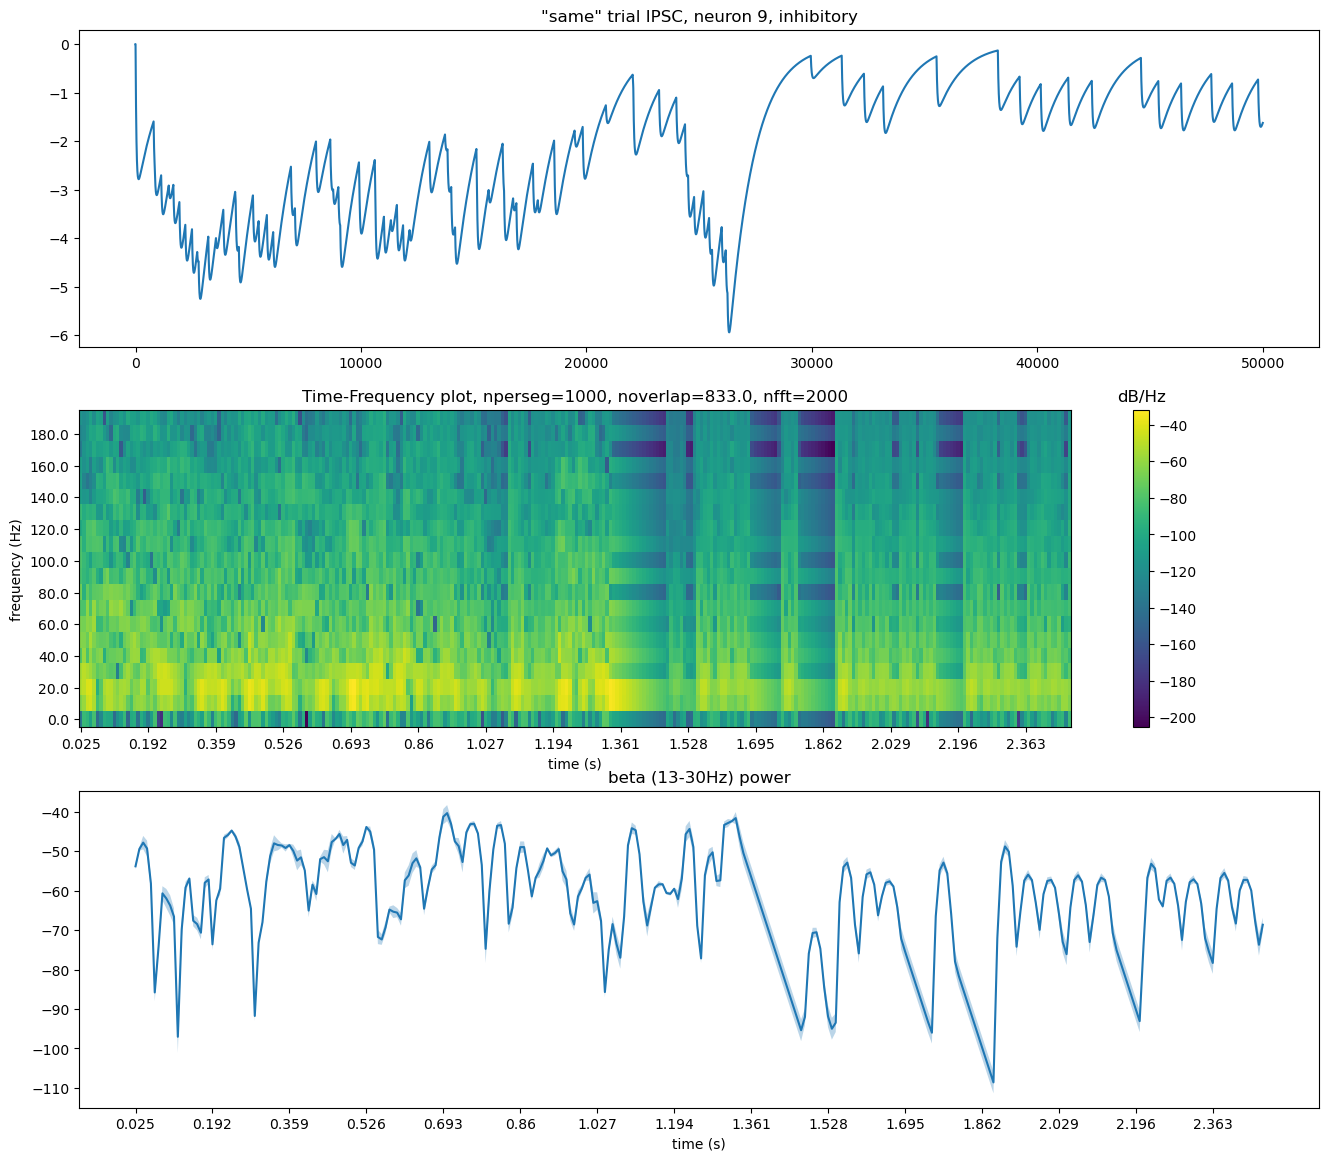

In [46]:
# plotting inhibitory

fs = 20000
nperseg=1000
noverlap = nperseg//1.2
nfft = nperseg*2
f_cutoff = 200

f, t, s = calc_spect(same_IPSCs, fs=fs, nperseg=nperseg, 
                     noverlap=noverlap, nfft=nfft, f_cutoff=f_cutoff, 
                     plot=1, neuron_nums=inh_ind[:3], t_skip=20, f_skip=2, trial_label='same')

#### "diff" trial

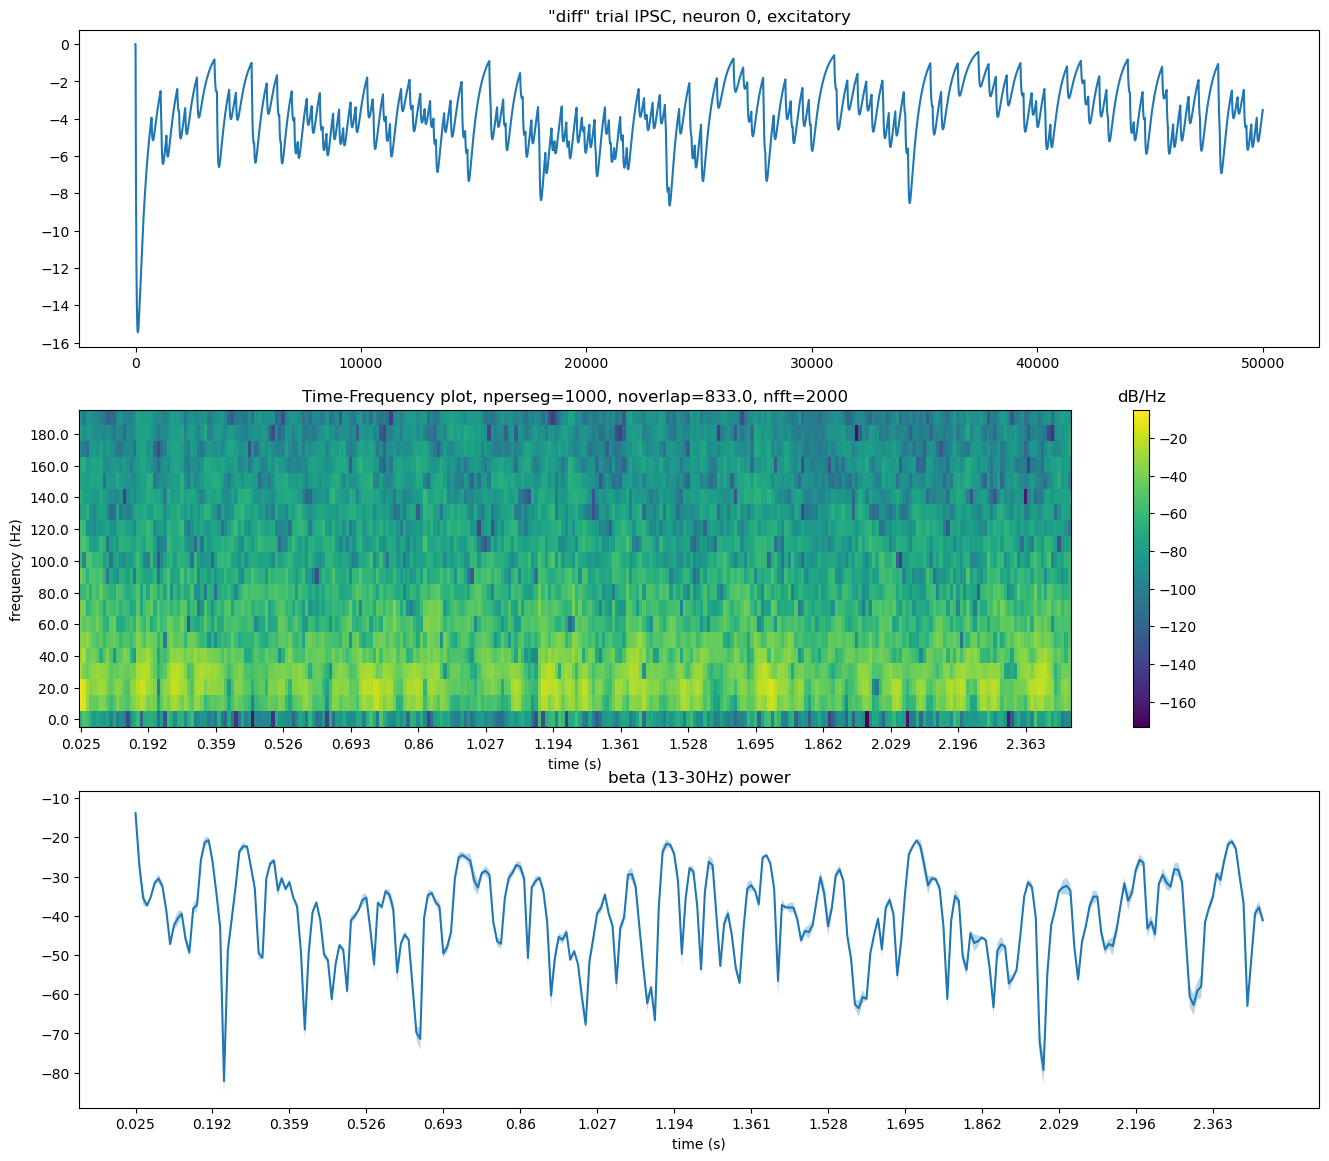

In [48]:
fs = 20000
nperseg=1000
noverlap = nperseg//1.2
nfft = nperseg*2
f_cutoff = 200

f, t, s = calc_spect(diff_IPSCs, fs=fs, nperseg=nperseg, 
                     noverlap=noverlap, nfft=nfft, f_cutoff=f_cutoff, 
                     plot=1, neuron_nums=[0], t_skip=20, f_skip=2, trial_label='diff')

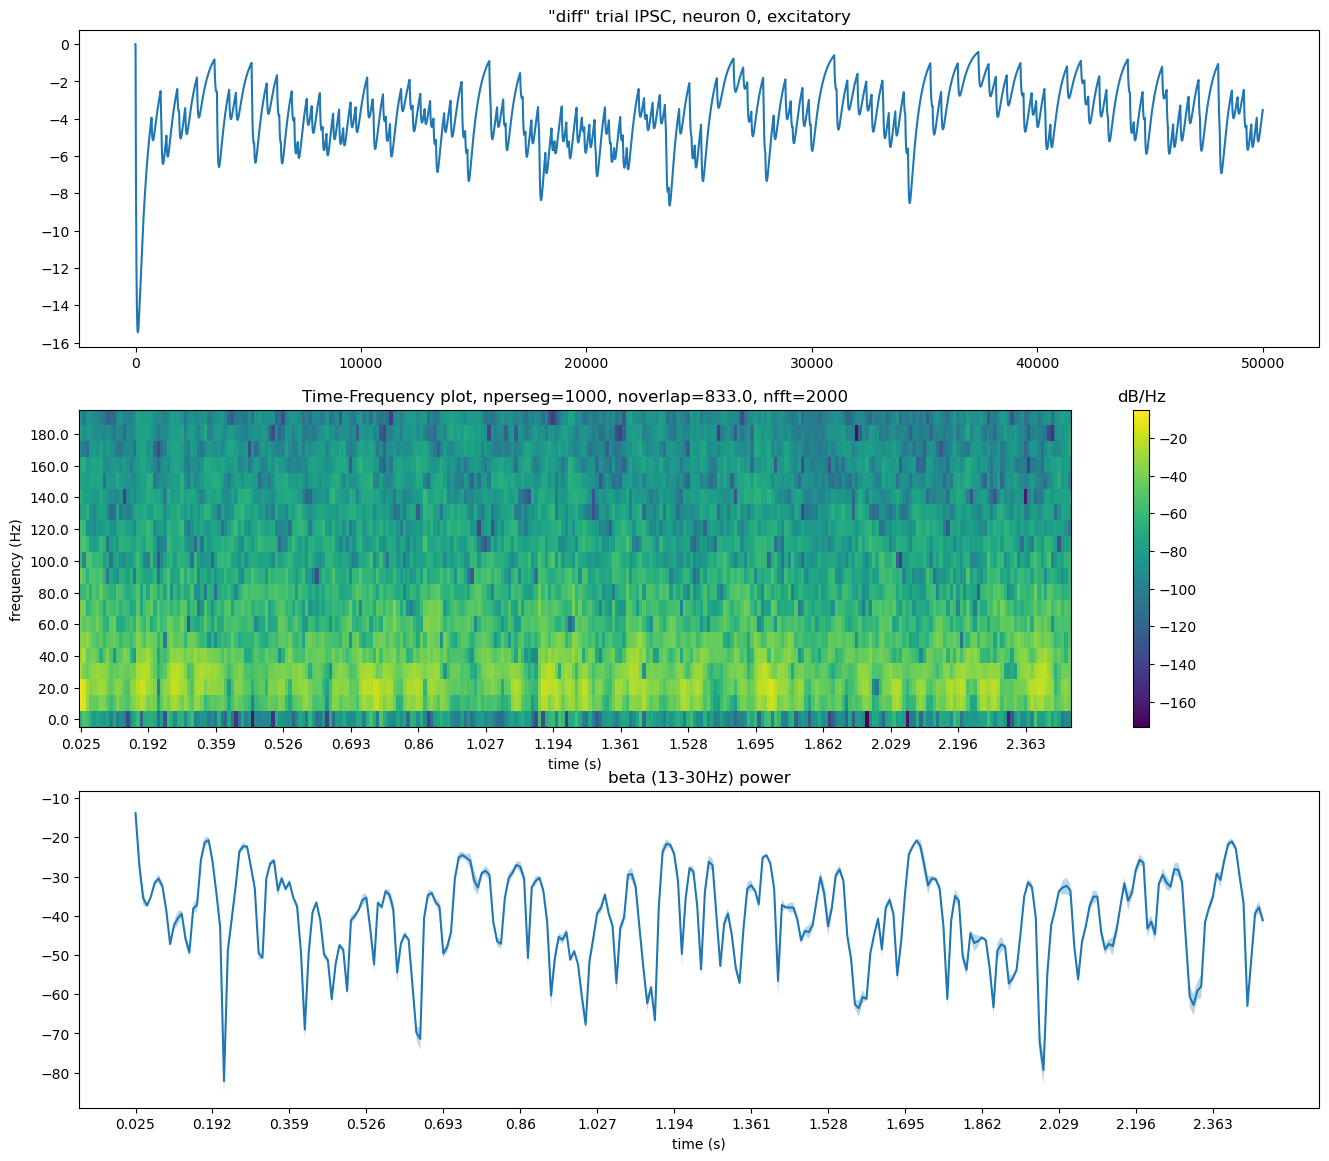

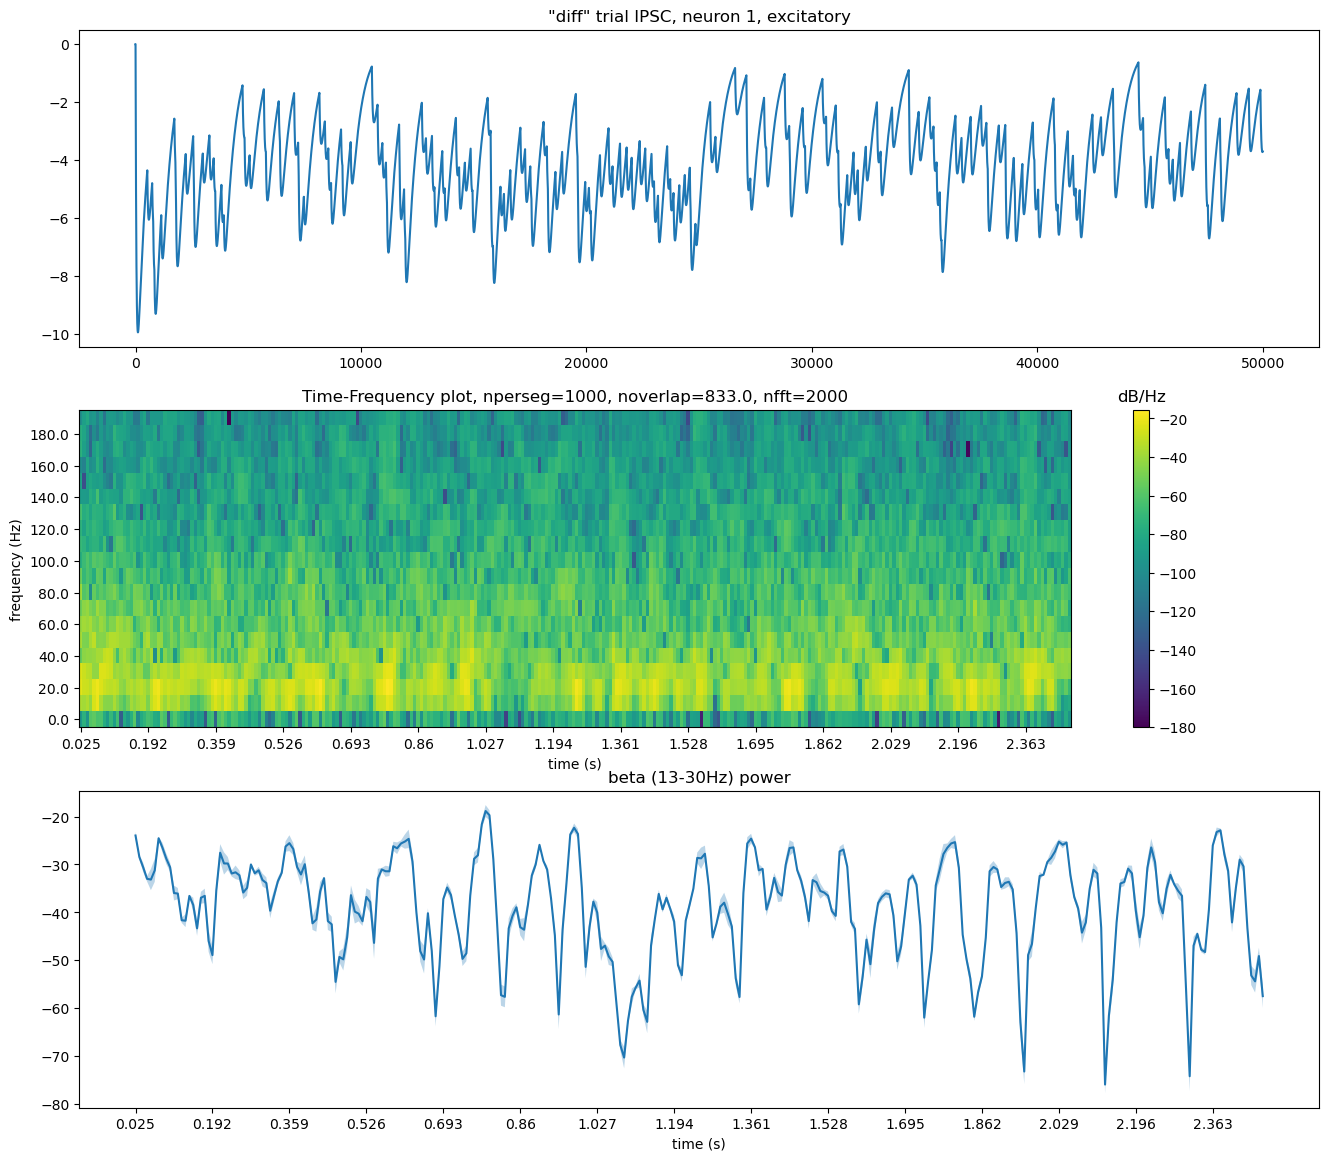

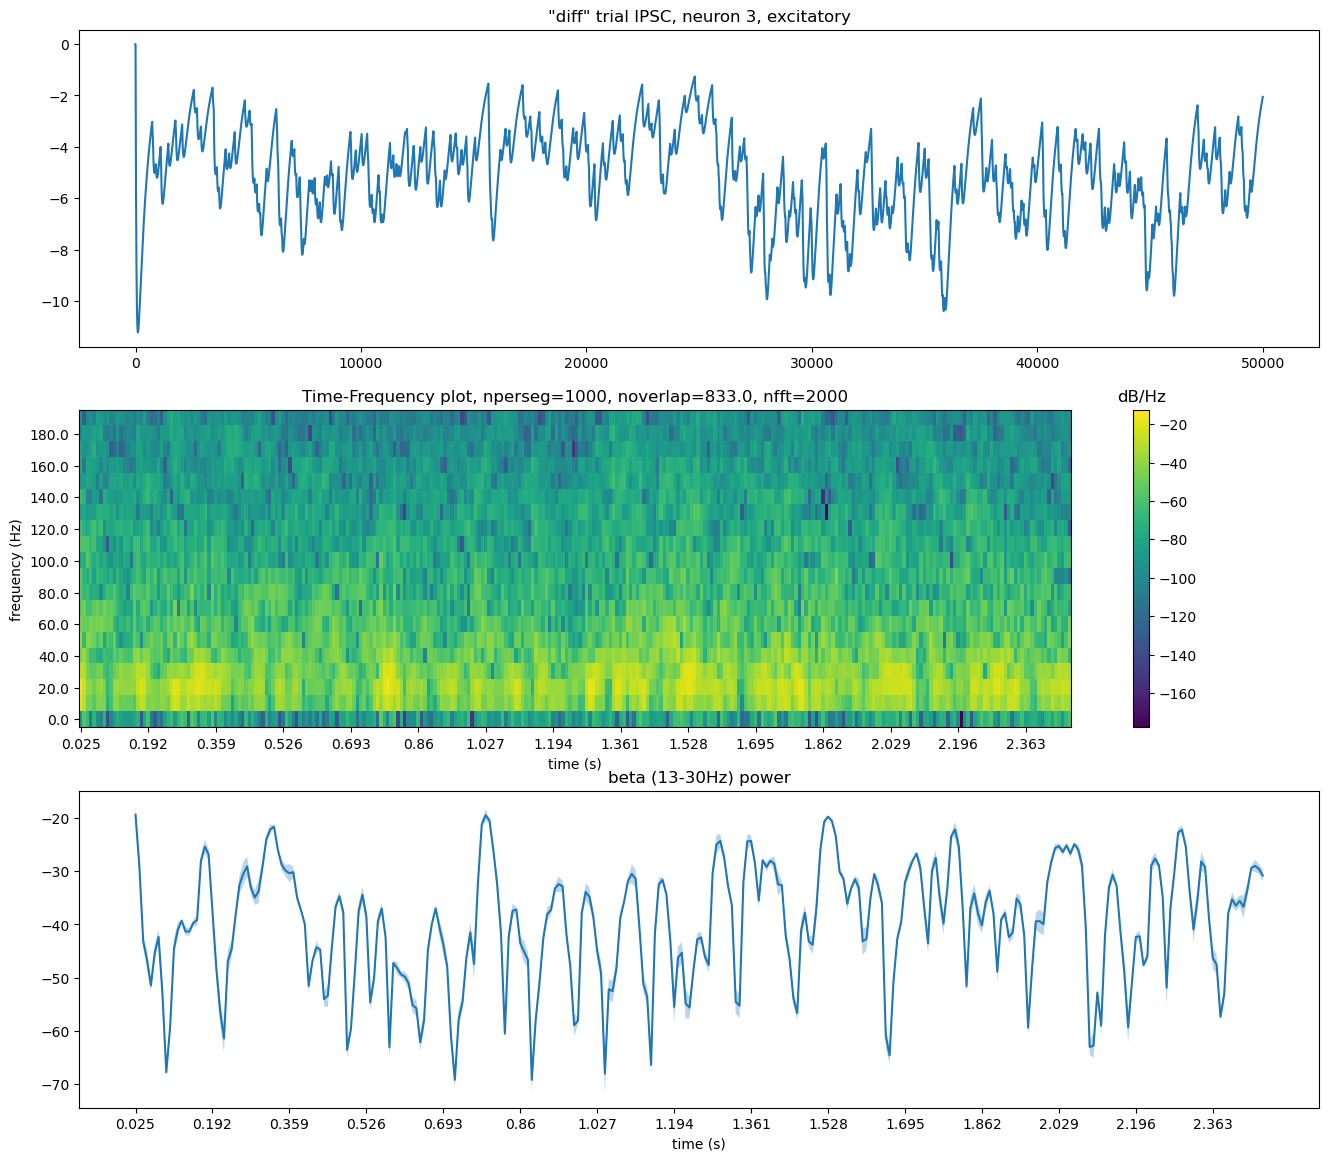

In [52]:
# plotting excitatory

fs = 20000
nperseg=1000
noverlap = nperseg//1.2
nfft = nperseg*2
f_cutoff = 200

f, t, s = calc_spect(diff_IPSCs, fs=fs, nperseg=nperseg, 
                     noverlap=noverlap, nfft=nfft, f_cutoff=f_cutoff, 
                     plot=1, neuron_nums=exc_ind[:3], t_skip=20, f_skip=2, trial_label='diff')

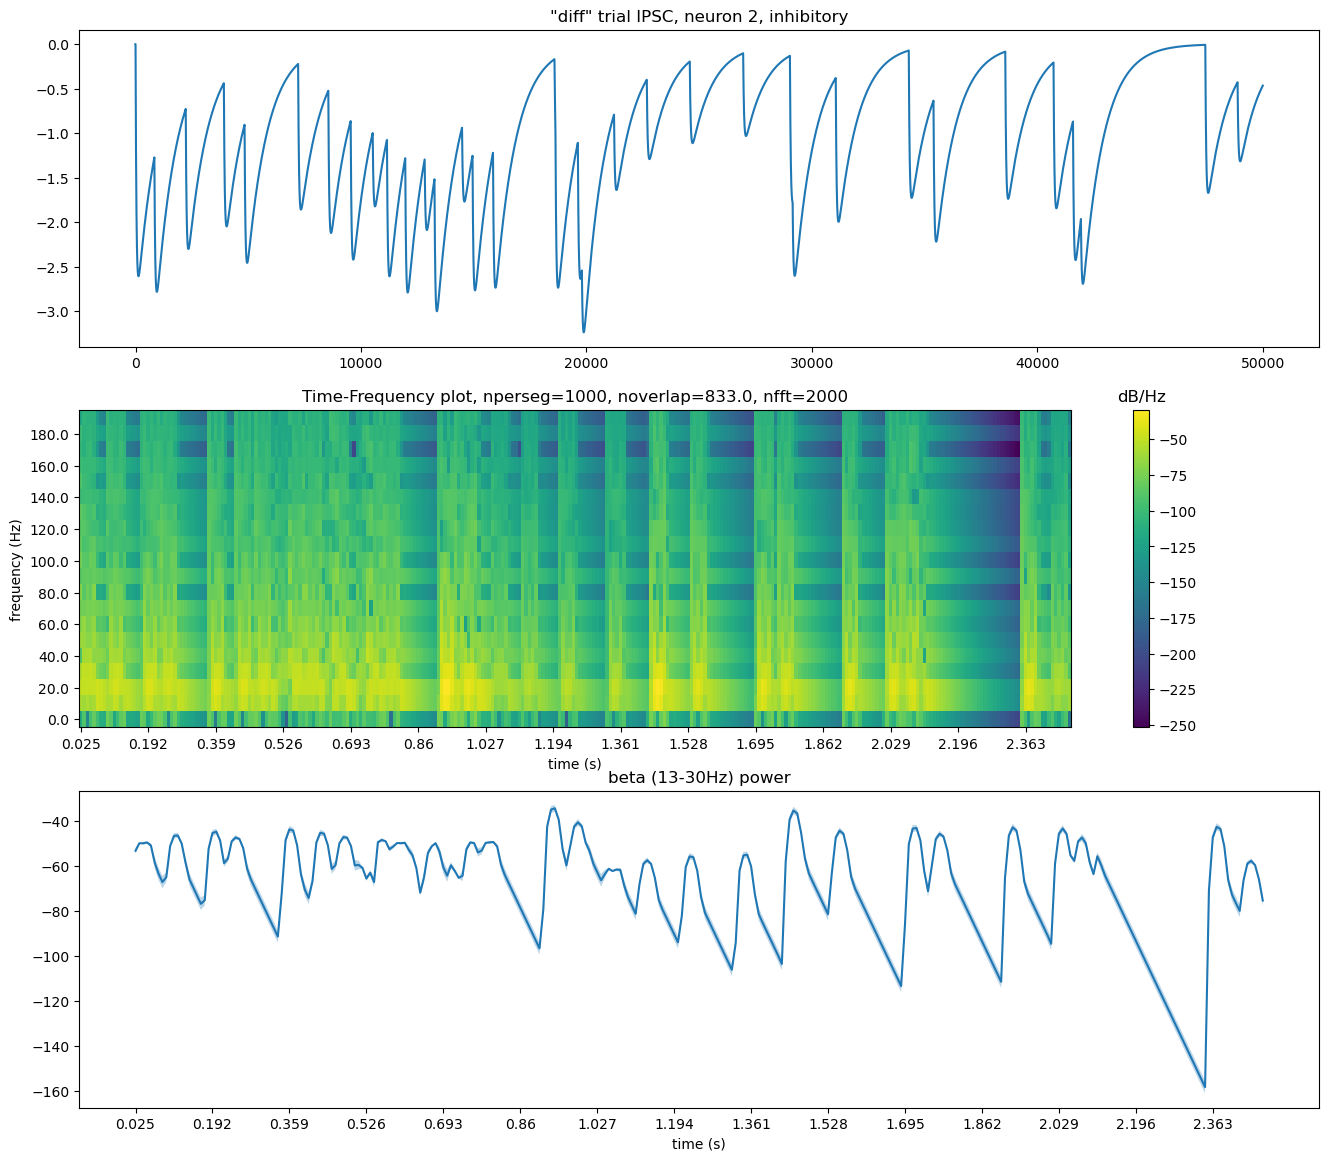

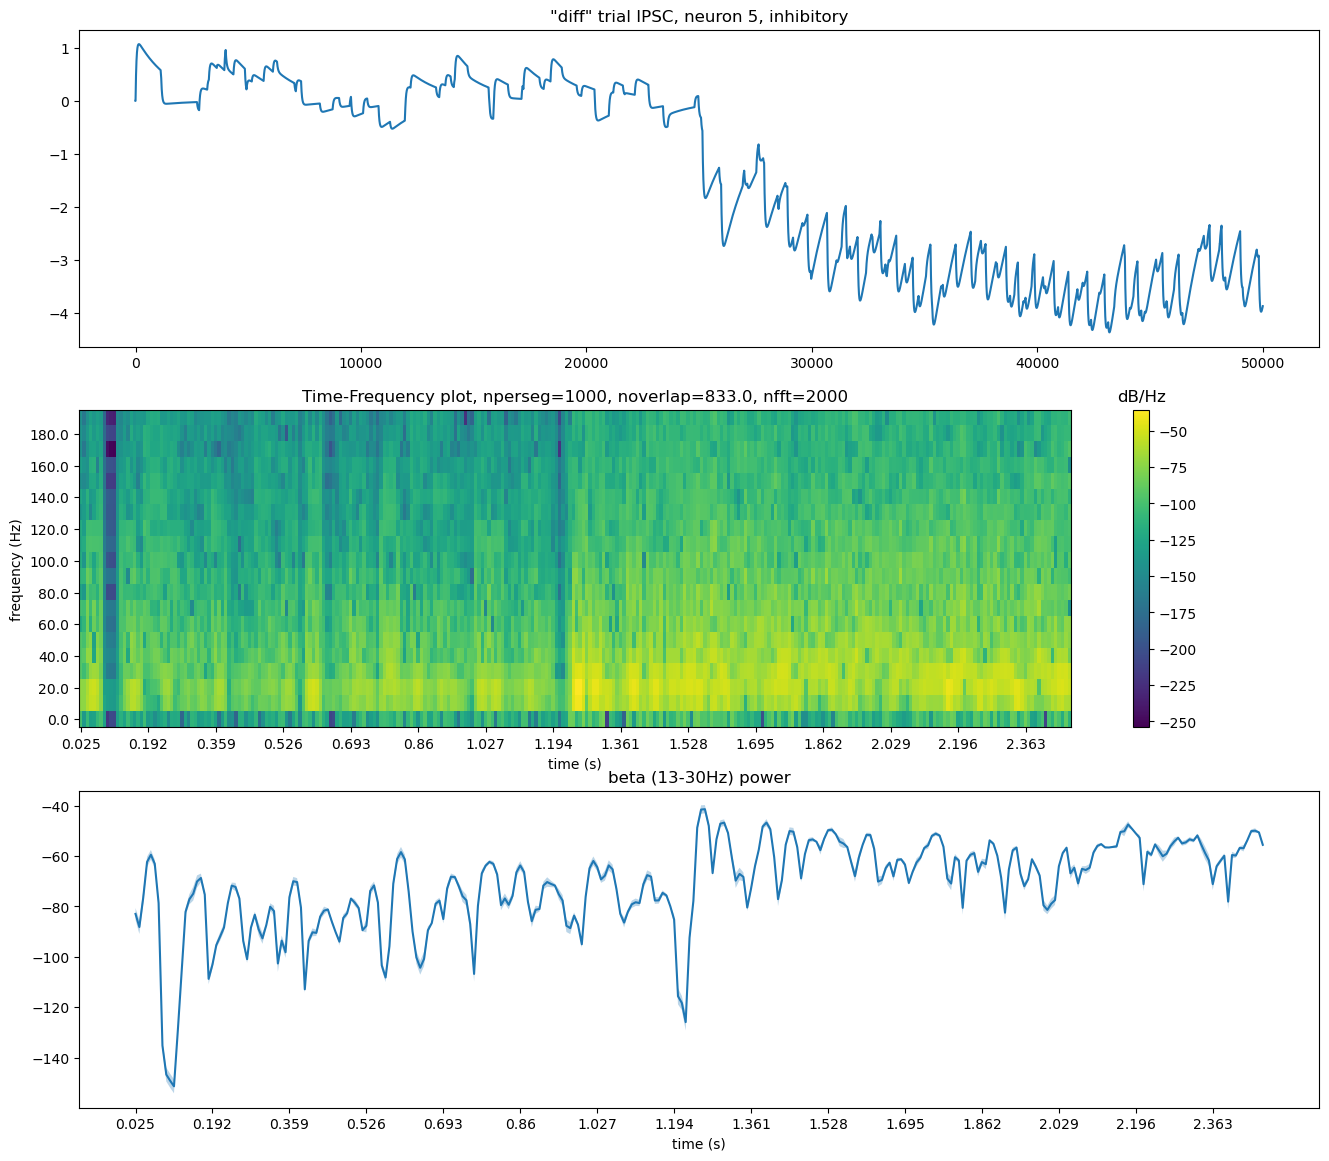

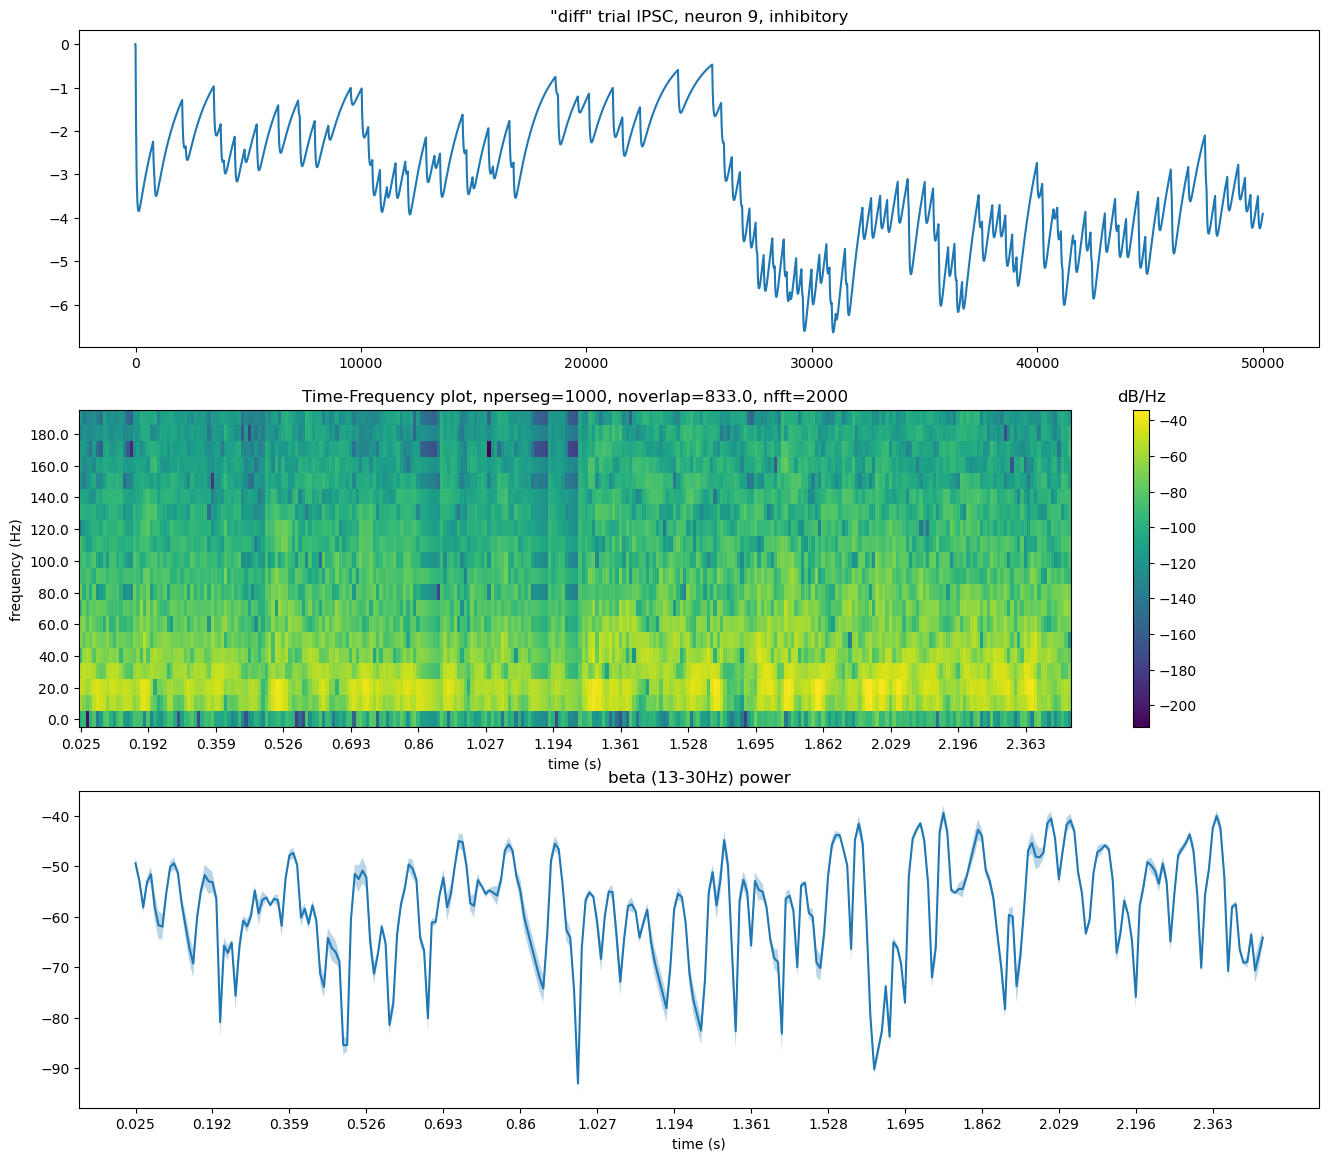

In [51]:
# plotting inhibitory

fs = 20000
nperseg=1000
noverlap = nperseg//1.2
nfft = nperseg*2
f_cutoff = 200

f, t, s = calc_spect(diff_IPSCs, fs=fs, nperseg=nperseg, 
                     noverlap=noverlap, nfft=nfft, f_cutoff=f_cutoff, 
                     plot=1, neuron_nums=inh_ind[:3], t_skip=20, f_skip=2, trial_label='diff')

### Phase-Amplitude Coupling

In [5]:
import tensorpac

In [6]:
ipsc_data = scipy.io.loadmat(os.path.join(model_dir, model_fname, 'diffIPSCs15.mat'))
ipsc_data.keys()

diff_IPSCs_15 = ipsc_data['diff_IPSCs']
print(diff_IPSCs_15.shape)

(200, 50000, 15)


https://etiennecmb.github.io/tensorpac/

#### Event-related PAC

first, get the data in the right format for the event-related PACs tutorial (https://etiennecmb.github.io/tensorpac/auto_examples/tuto/plot_real_data.html#sphx-glr-auto-examples-tuto-plot-real-data-py)
- data (n_trials, n_times)
- fs (sampling freq)
- times (range times)

In [7]:
fs = 20000
times = np.arange(diff_IPSCs_15.shape[1])
data = diff_IPSCs_15[0,:,:].T # 1 neuron, trials x times
n_trials = data.shape[0]
print(data.shape)

(15, 50000)


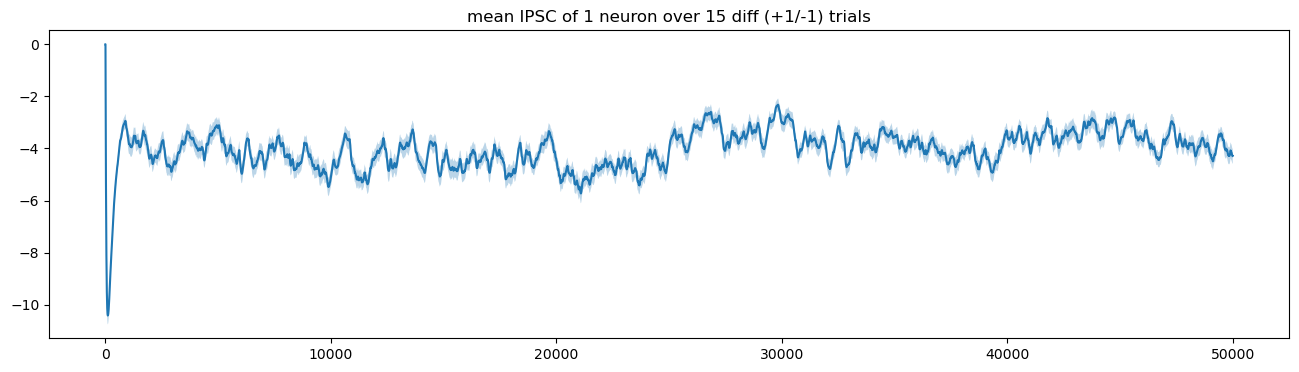

In [8]:
plt.figure(figsize=(16,4))
ipsc_mean = np.nanmean(data, axis=0)
ipsc_sem = np.sqrt(np.nanstd(data, axis=0))/np.sqrt(n_trials)
plt.plot(ipsc_mean)
plt.fill_between(times, ipsc_mean-ipsc_sem, ipsc_mean+ipsc_sem, alpha=0.3)
plt.title(f'mean IPSC of 1 neuron over {n_trials} diff (+1/-1) trials')
plt.show()

In [ ]:
from tensorpac import Pac, EventRelatedPac, PreferredPhase
from tensorpac.utils import PeakLockedTF, PSD, ITC, BinAmplitude

Event Related PAC object defined
    Extract phases (n_pha=1) and amplitudes (n_amps=168)
    Compute ERPAC (Voytek et al. 2013)
    Correct p-values for multiple-comparisons using fdr correction of MNE-Python


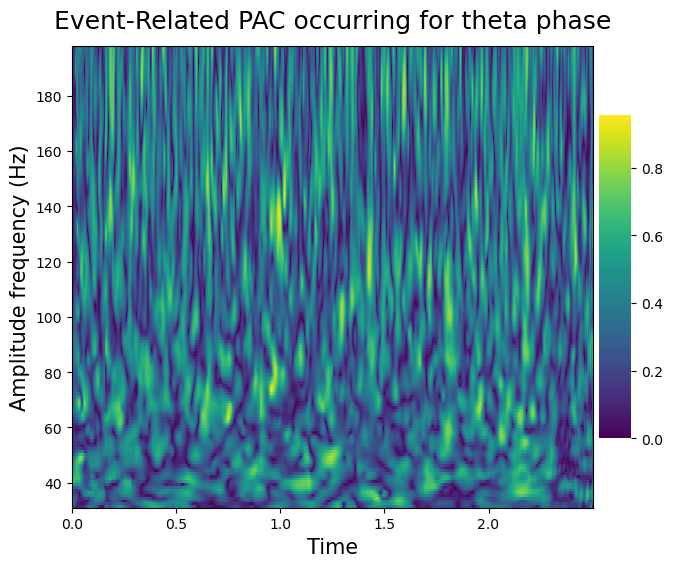

In [9]:
# following the params in the example
rp_obj = tensorpac.EventRelatedPac(f_pha=[4, 8], f_amp=(30, 200, 2, 1), dcomplex='hilbert', 
                         cycle=(3,6), width=7)
erpac = rp_obj.filterfit(fs, data, method='circular')

plt.figure(figsize=(8, 6))
rp_obj.pacplot(erpac.squeeze(), times/fs, rp_obj.yvec, xlabel='Time',
               ylabel='Amplitude frequency (Hz)',
               title='Event-Related PAC occurring for theta phase',
               fz_labels=15, fz_title=18)
plt.show()

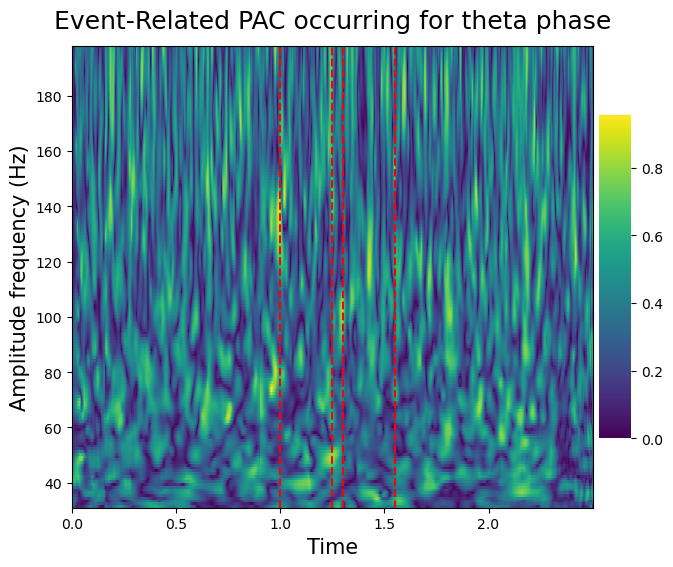

In [14]:
plt.figure(figsize=(8, 6))
rp_obj.pacplot(erpac.squeeze(), times/fs, rp_obj.yvec, xlabel='Time',
               ylabel='Amplitude frequency (Hz)',
               title='Event-Related PAC occurring for theta phase',
               fz_labels=15, fz_title=18)
plt.axvline(settings['stim_on']/fs*100, color='r', linestyle='--')
plt.axvline((settings['stim_on']+settings['stim_dur'])/fs*100, color='r', linestyle='--')
plt.axvline((settings['stim_on']+settings['stim_dur']+settings['delay'])/fs*100, color='r', linestyle='--')
plt.axvline((settings['stim_on']+2*settings['stim_dur']+settings['delay'])/fs*100, color='r', linestyle='--')
plt.show()

#### PACs (not event-related)

get the data in the right format
- data (n_times)  -- collapse the trial dimension
- fs (sampling freq)
- times (range times)

In [22]:
data.shape

(15, 50000)

In [15]:
data_flat = data.reshape((-1))
data_flat.shape

(750000,)

In [17]:
pac_obj = tensorpac.Pac(idpac=(2,1,0), f_pha=(1, 16, 2, 1), f_amp=(30, 150, 2, 1), dcomplex='hilbert',
                        cycle=(3, 6), width=2, n_bins=18)

pac = pac_obj.filterfit(fs, data_flat)

Phase Amplitude Coupling object defined
    extract phases (n_pha=13) and amplitudes (n_amps=118)
    true PAC estimation using Modulation Index (MI, Tort et al. 2010)
    compute surrogates (Permute phase across trials (Tort et al. 2010), 200 permutations, random_state=9208)
    infer p-values at (p=0.05, mcp=maxstat)


WARNING | 3d pac array has been given as an input. Only 2d arrays are supported for plotting. Taking the mean across the last dimension


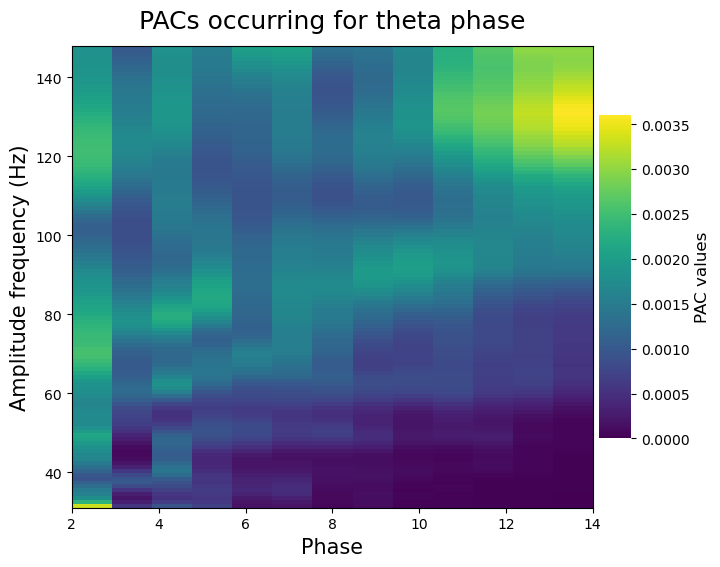

In [18]:
plt.figure(figsize=(8, 6))
pac_obj.comodulogram(pac, 
                     xlabel='Phase', ylabel='Amplitude frequency (Hz)',
                     title='PACs occurring for theta phase',
                     fz_labels=15, fz_title=18)
plt.show()

Try with z-scoring by surrogates

In [28]:
pac_obj = tensorpac.Pac(idpac=(2,1,4), f_pha=(1, 16, 2, 1), f_amp=(30, 150, 2, 1), dcomplex='hilbert',
                        cycle=(3, 6), width=2, n_bins=18)

pac = pac_obj.filterfit(fs, data_flat)

Phase Amplitude Coupling object defined
    extract phases (n_pha=13) and amplitudes (n_amps=118)


In [122]:
pac.shape

(168, 10, 1)

WARNING | 3d pac array has been given as an input. Only 2d arrays are supported for plotting. Taking the mean across the last dimension


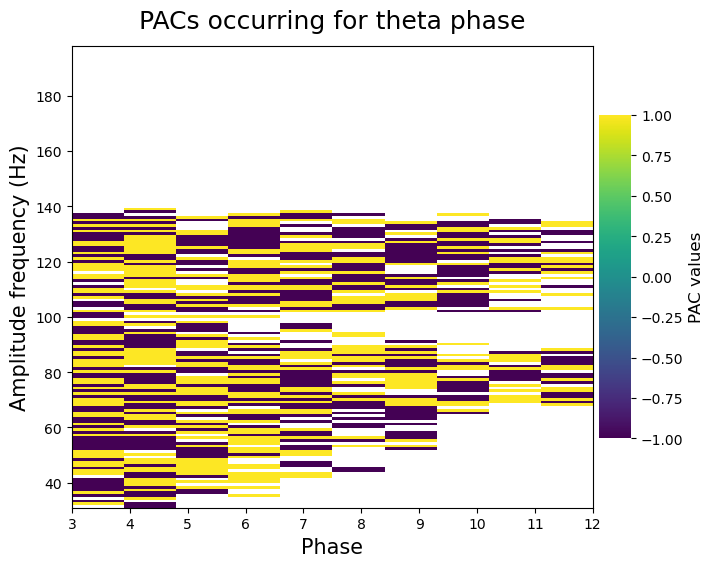

In [124]:
plt.figure(figsize=(8, 6))
pac_obj.comodulogram(pac, 
                     xlabel='Phase', ylabel='Amplitude frequency (Hz)',
                     title='PACs occurring for theta phase',
                     fz_labels=15, fz_title=18)
plt.show()